In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.nddata import Cutout2D
import numpy as np
from astropy.visualization import ZScaleInterval
from astropy.visualization import ImageNormalize
from scipy.stats import norm
from scipy import ndimage
import pyregion
from copy import copy


In [2]:
sys.path.append('/home/lupengjun/OII_emitter/photometry/code')
import multibandphotometry as mbp
from nebula import nebula

In [3]:
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 28
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.linewidth'] = 1

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


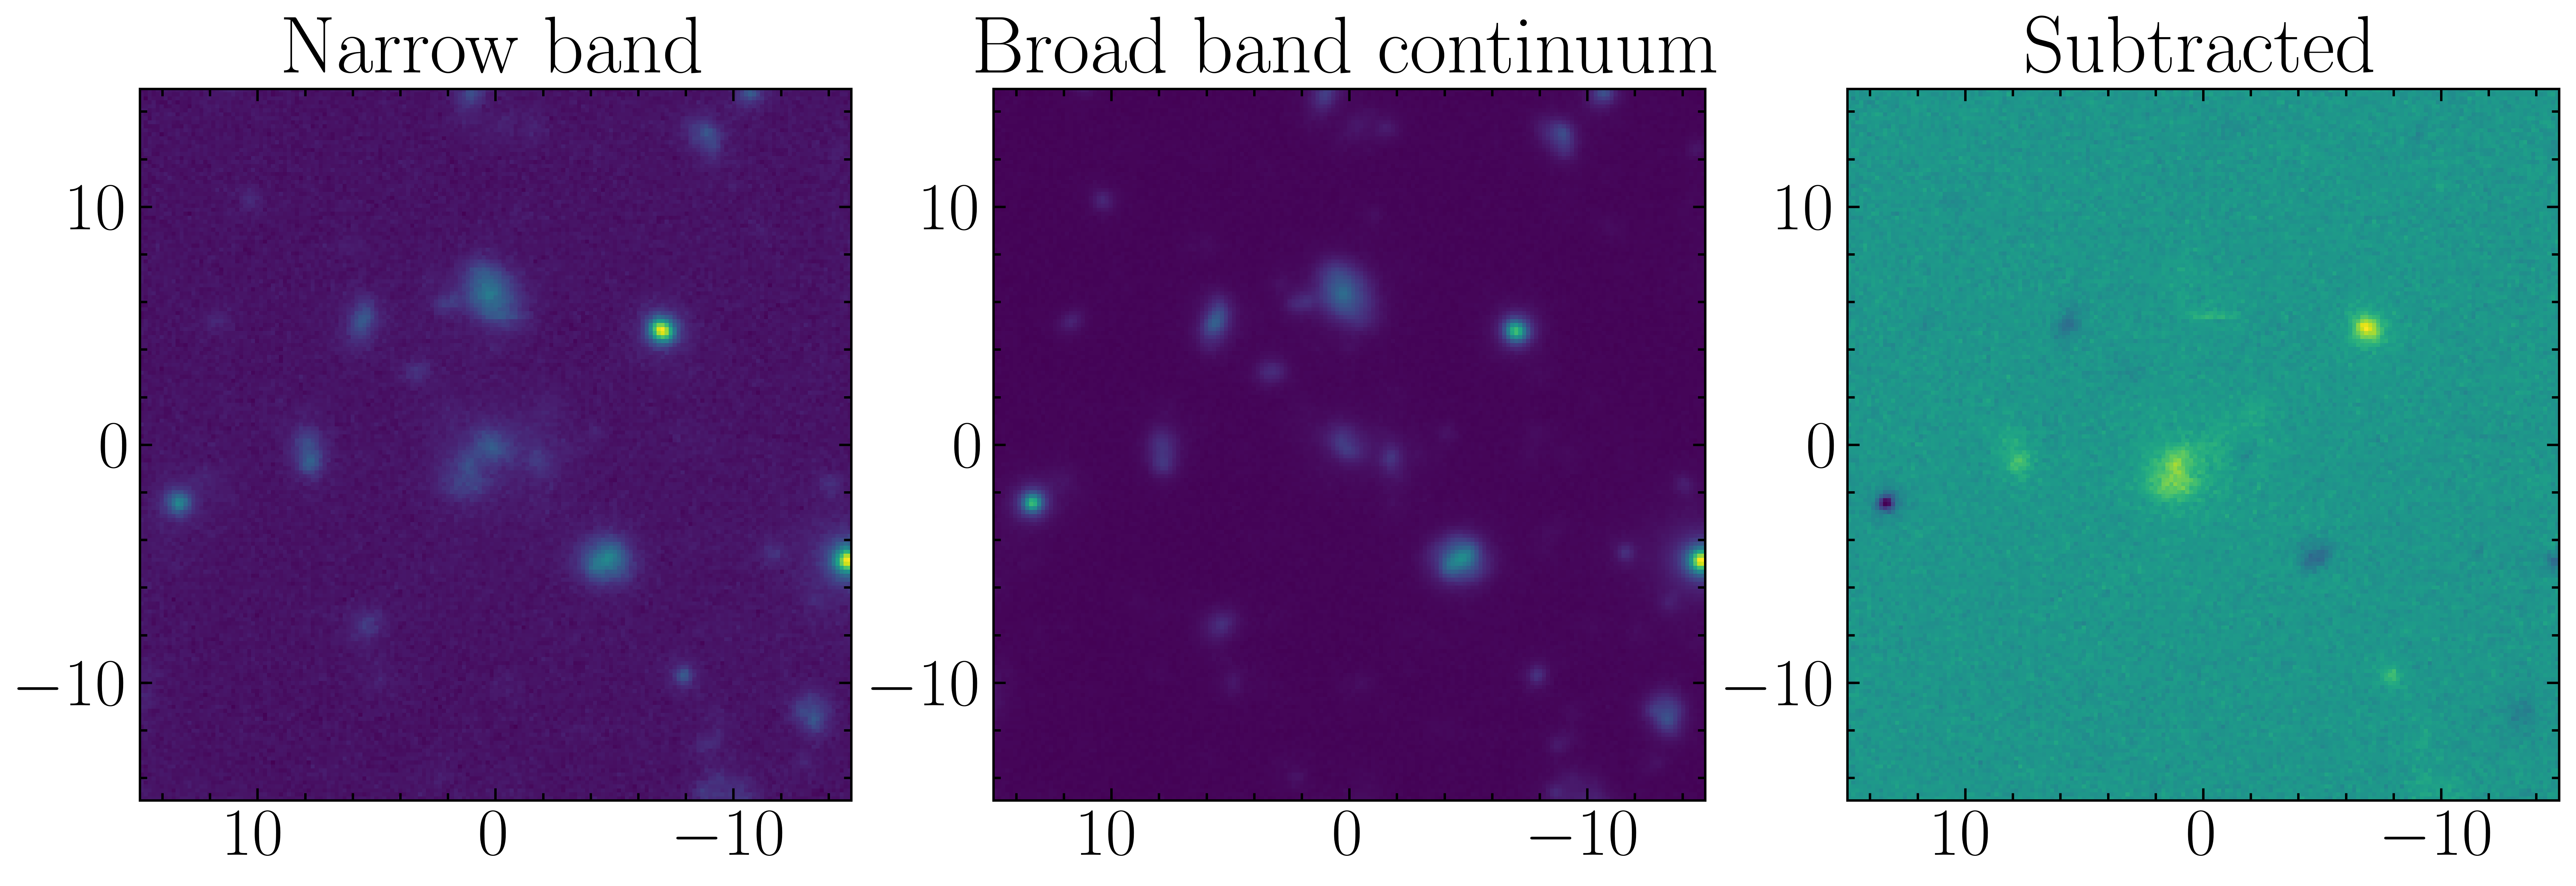

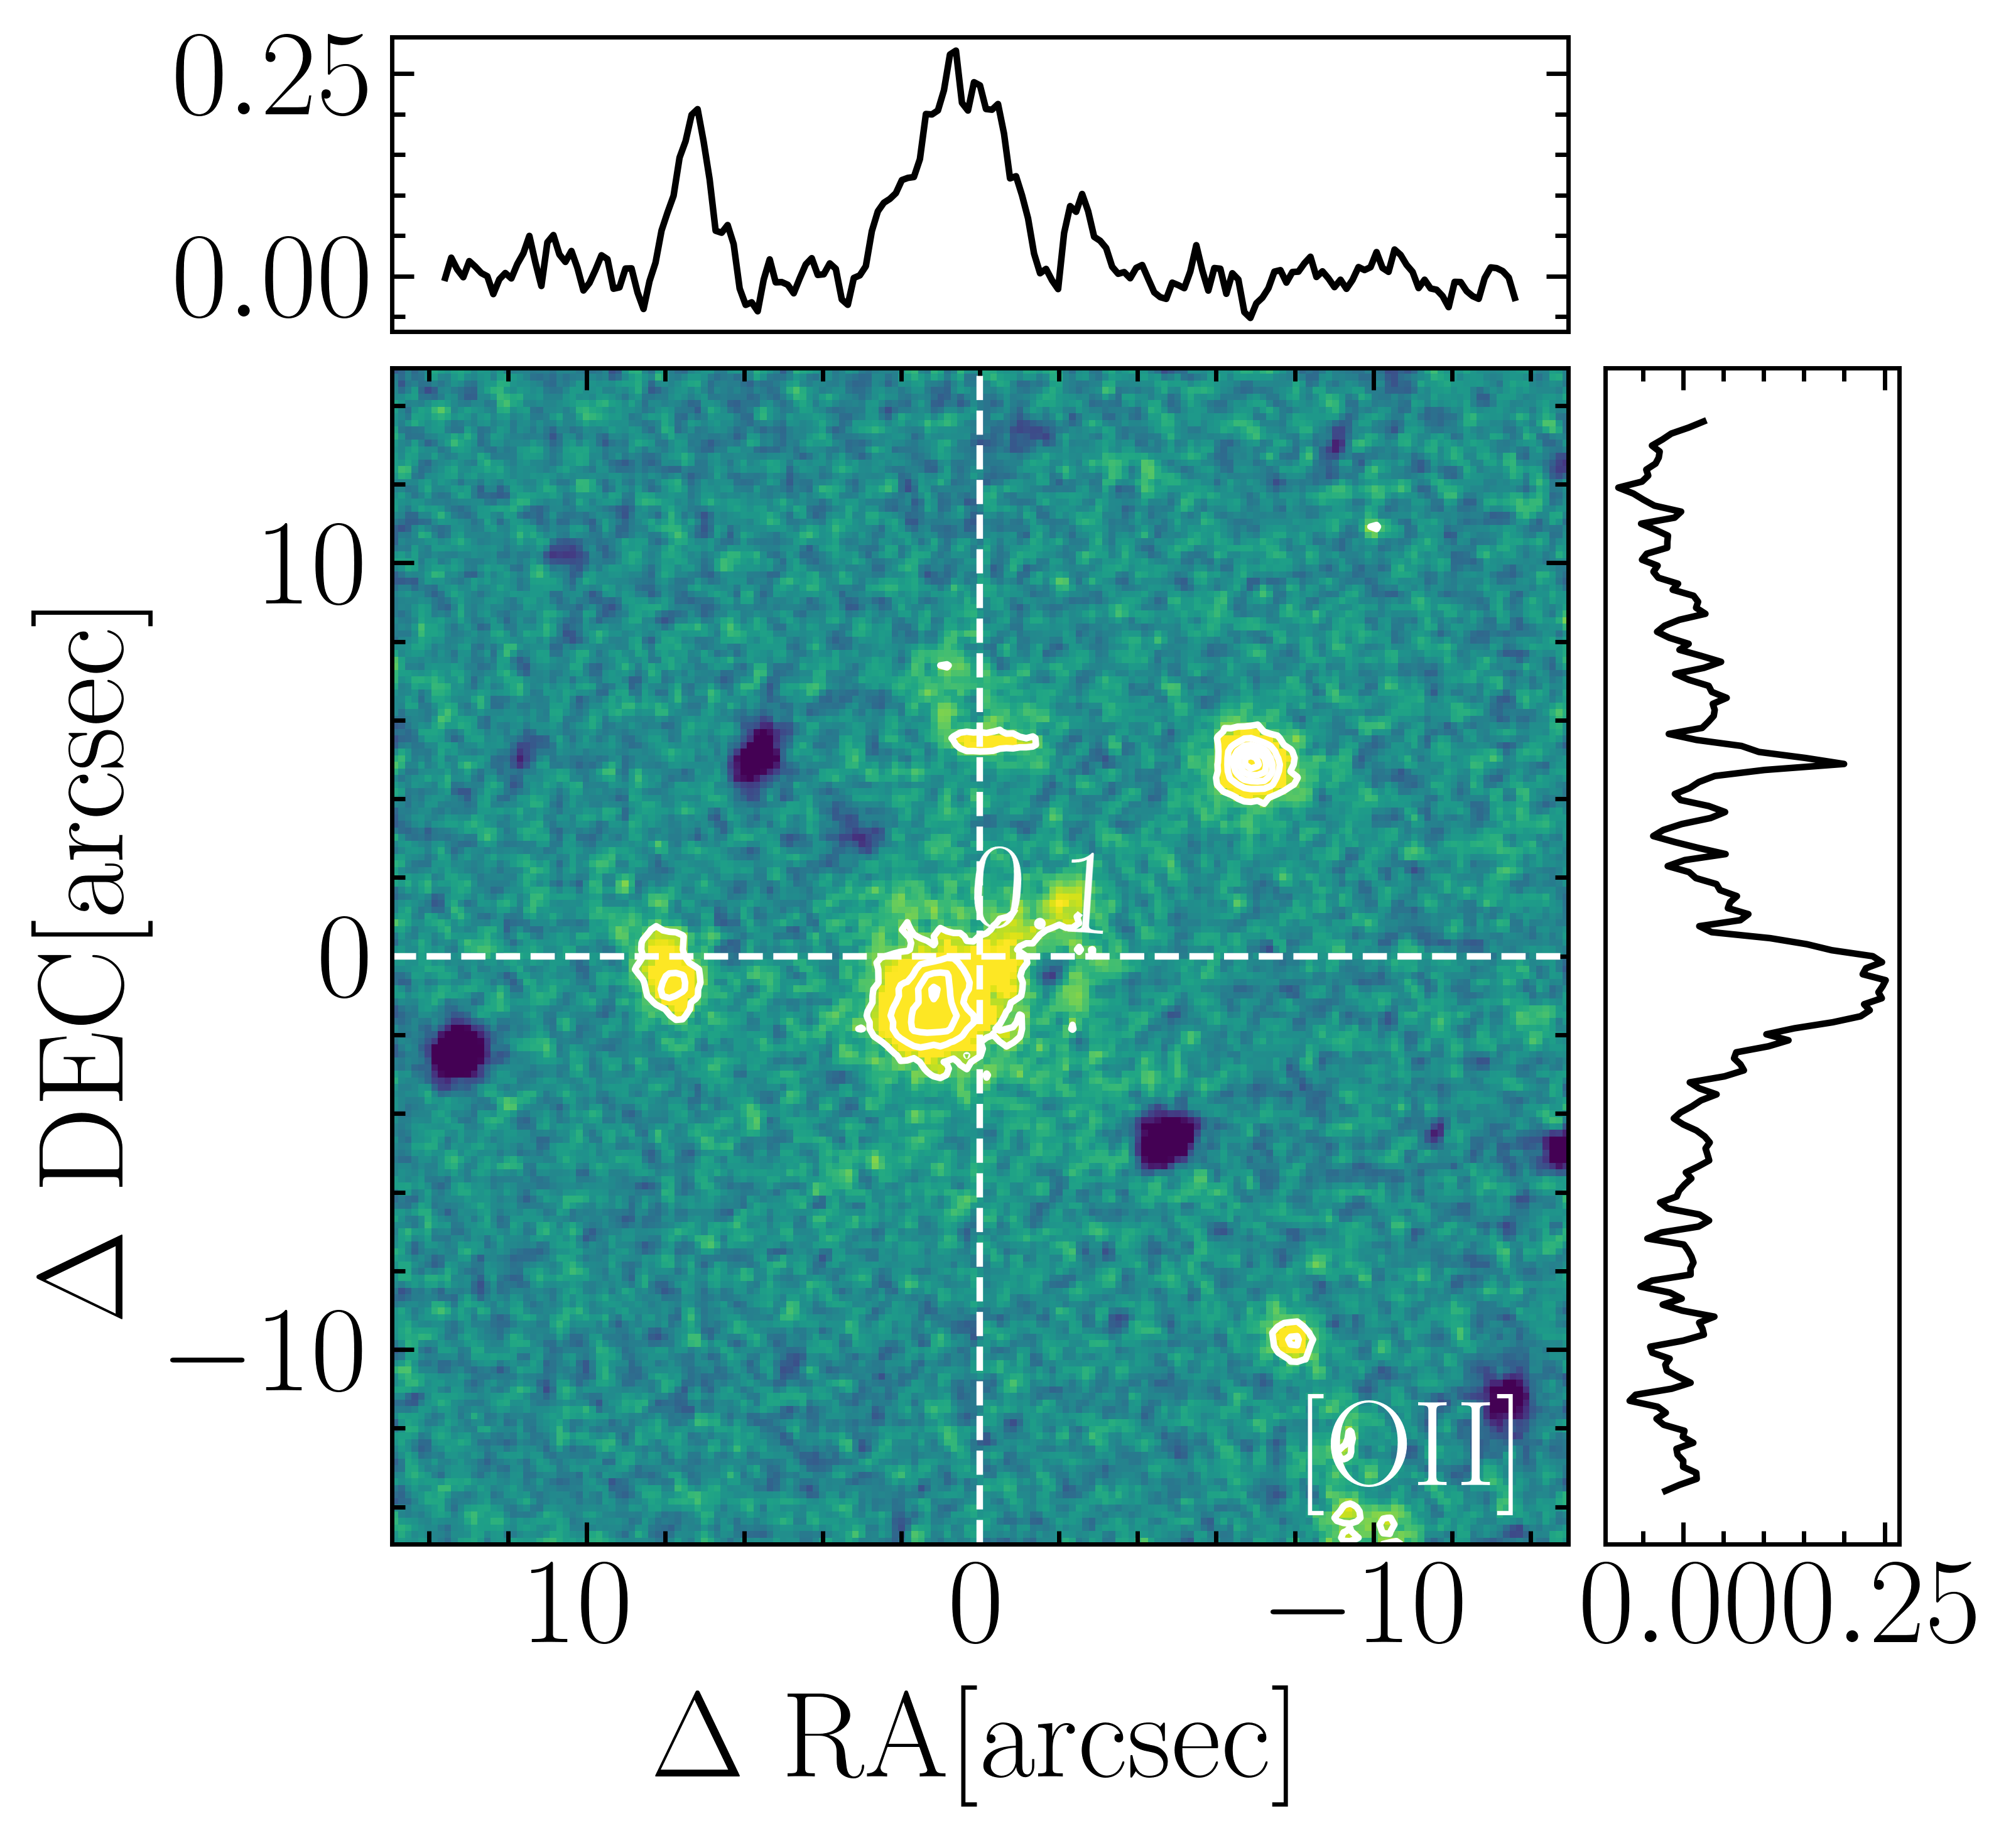

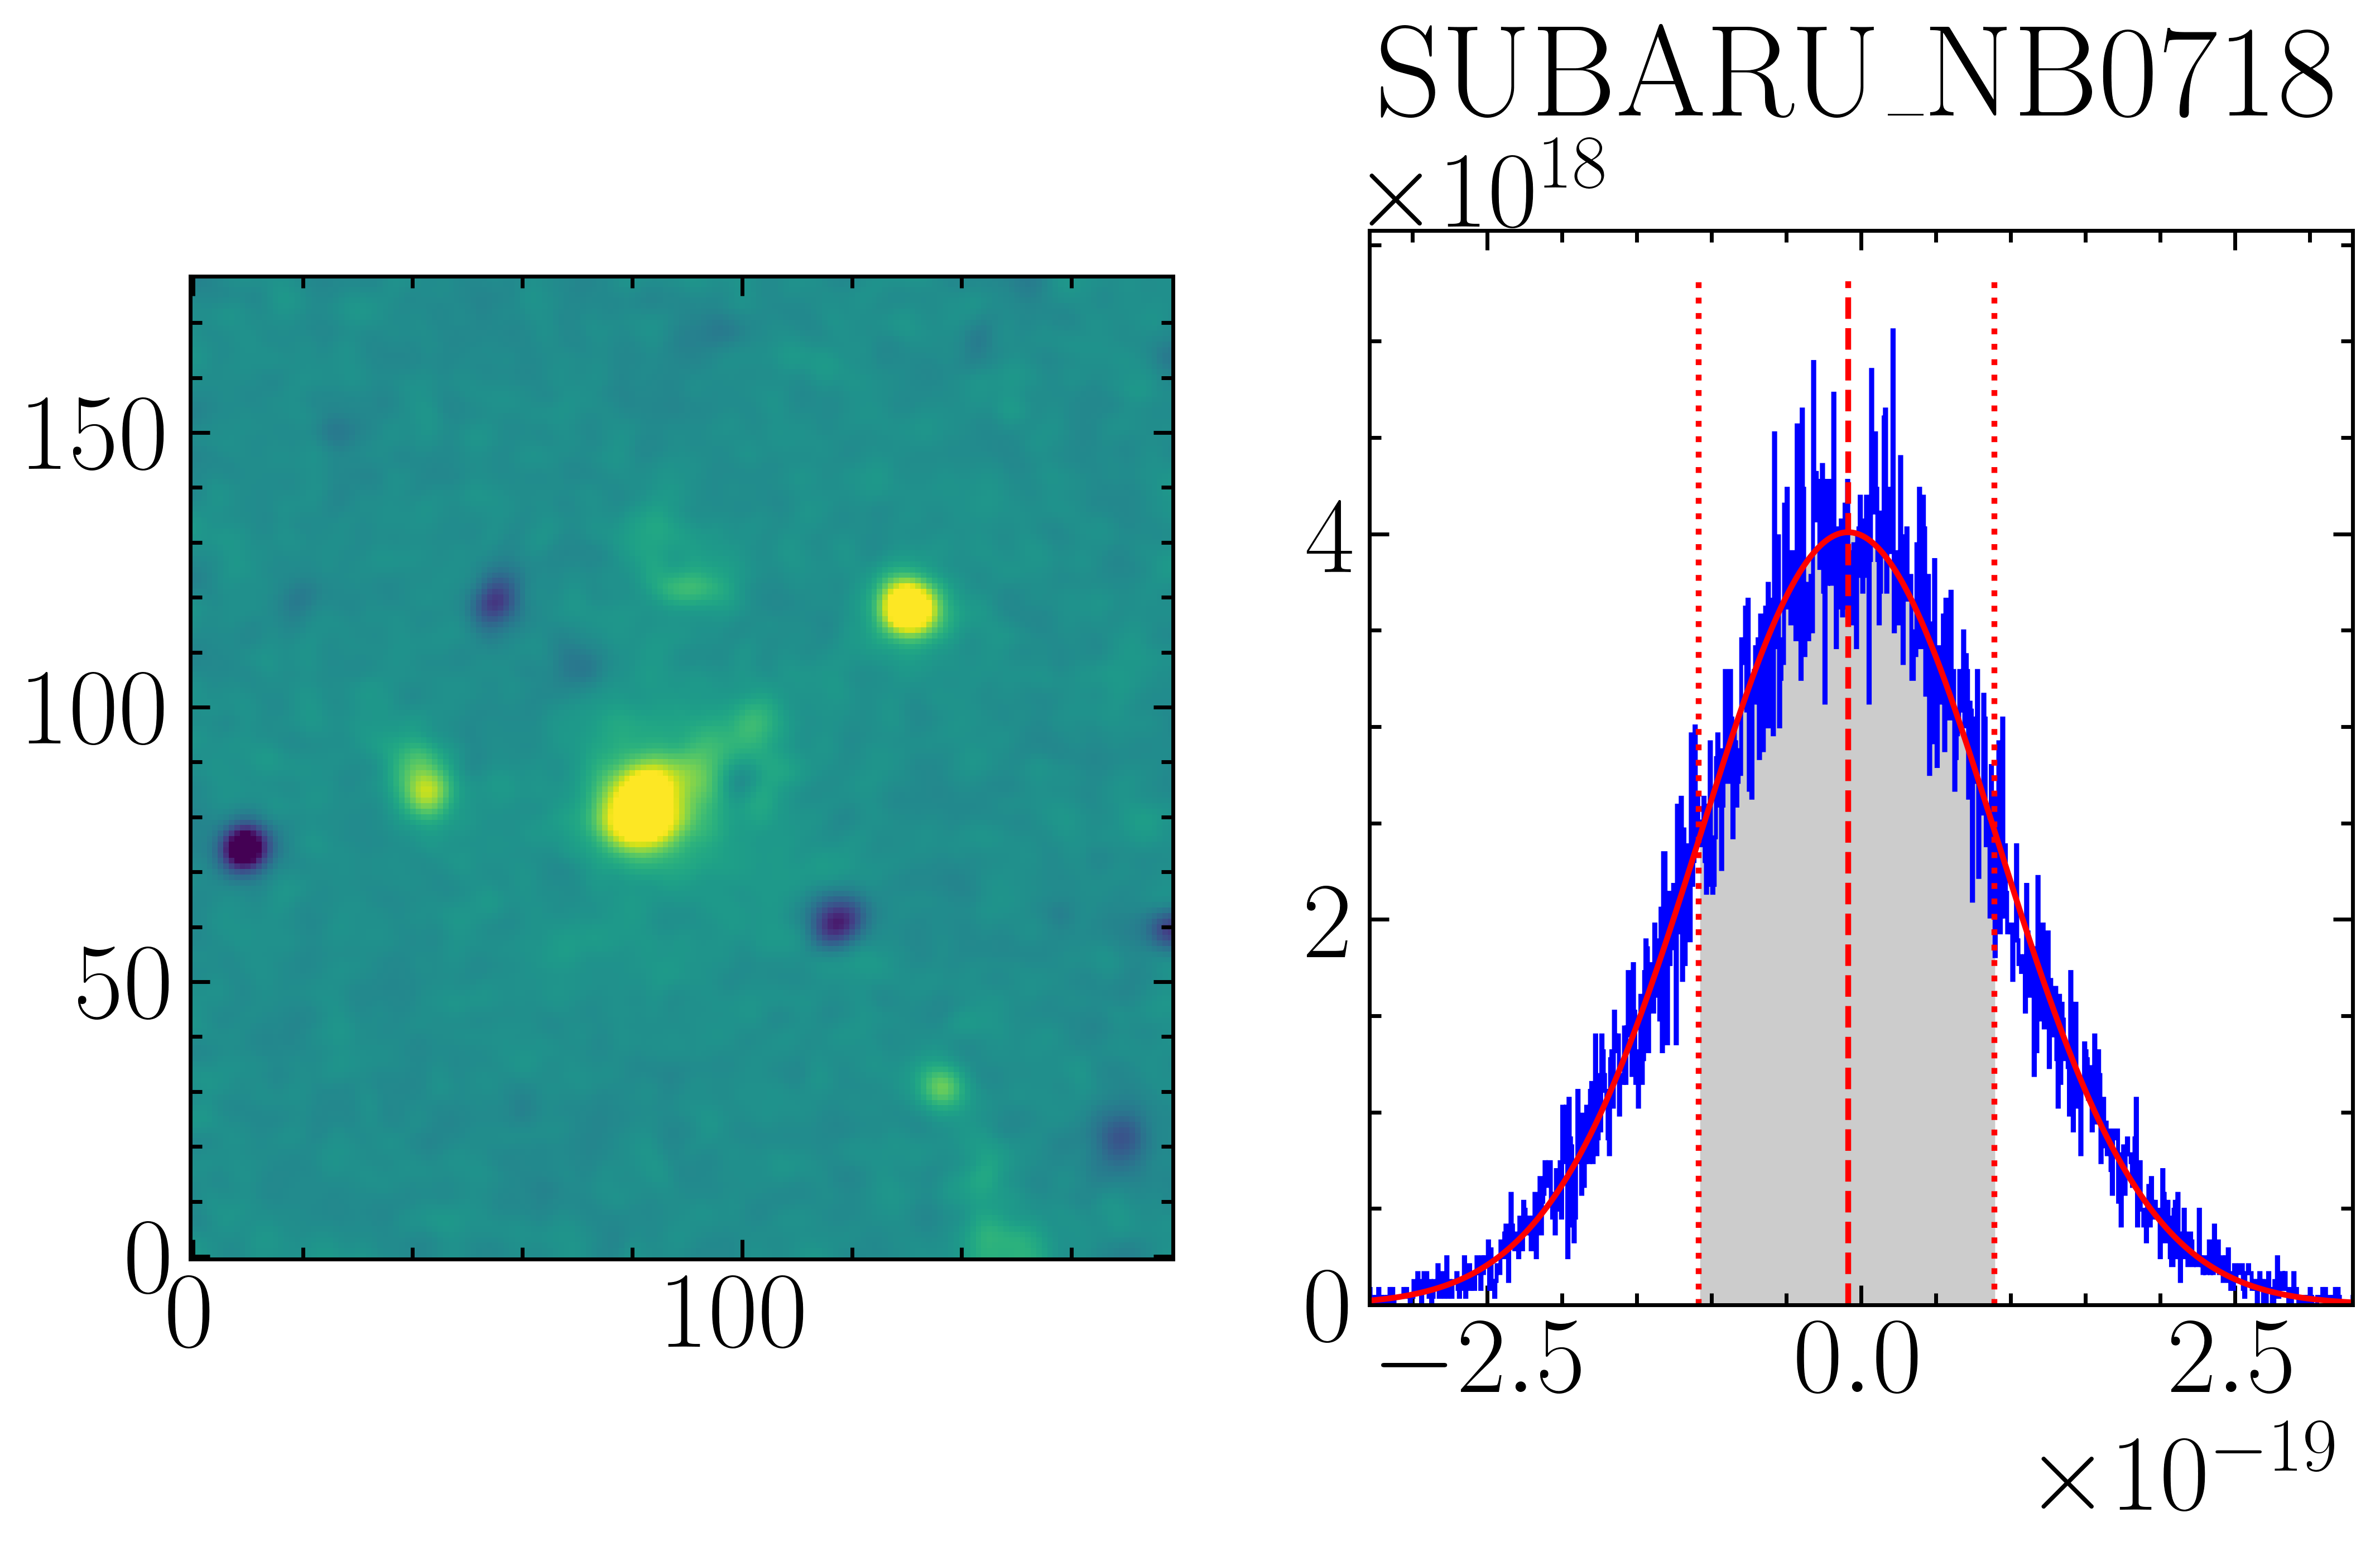

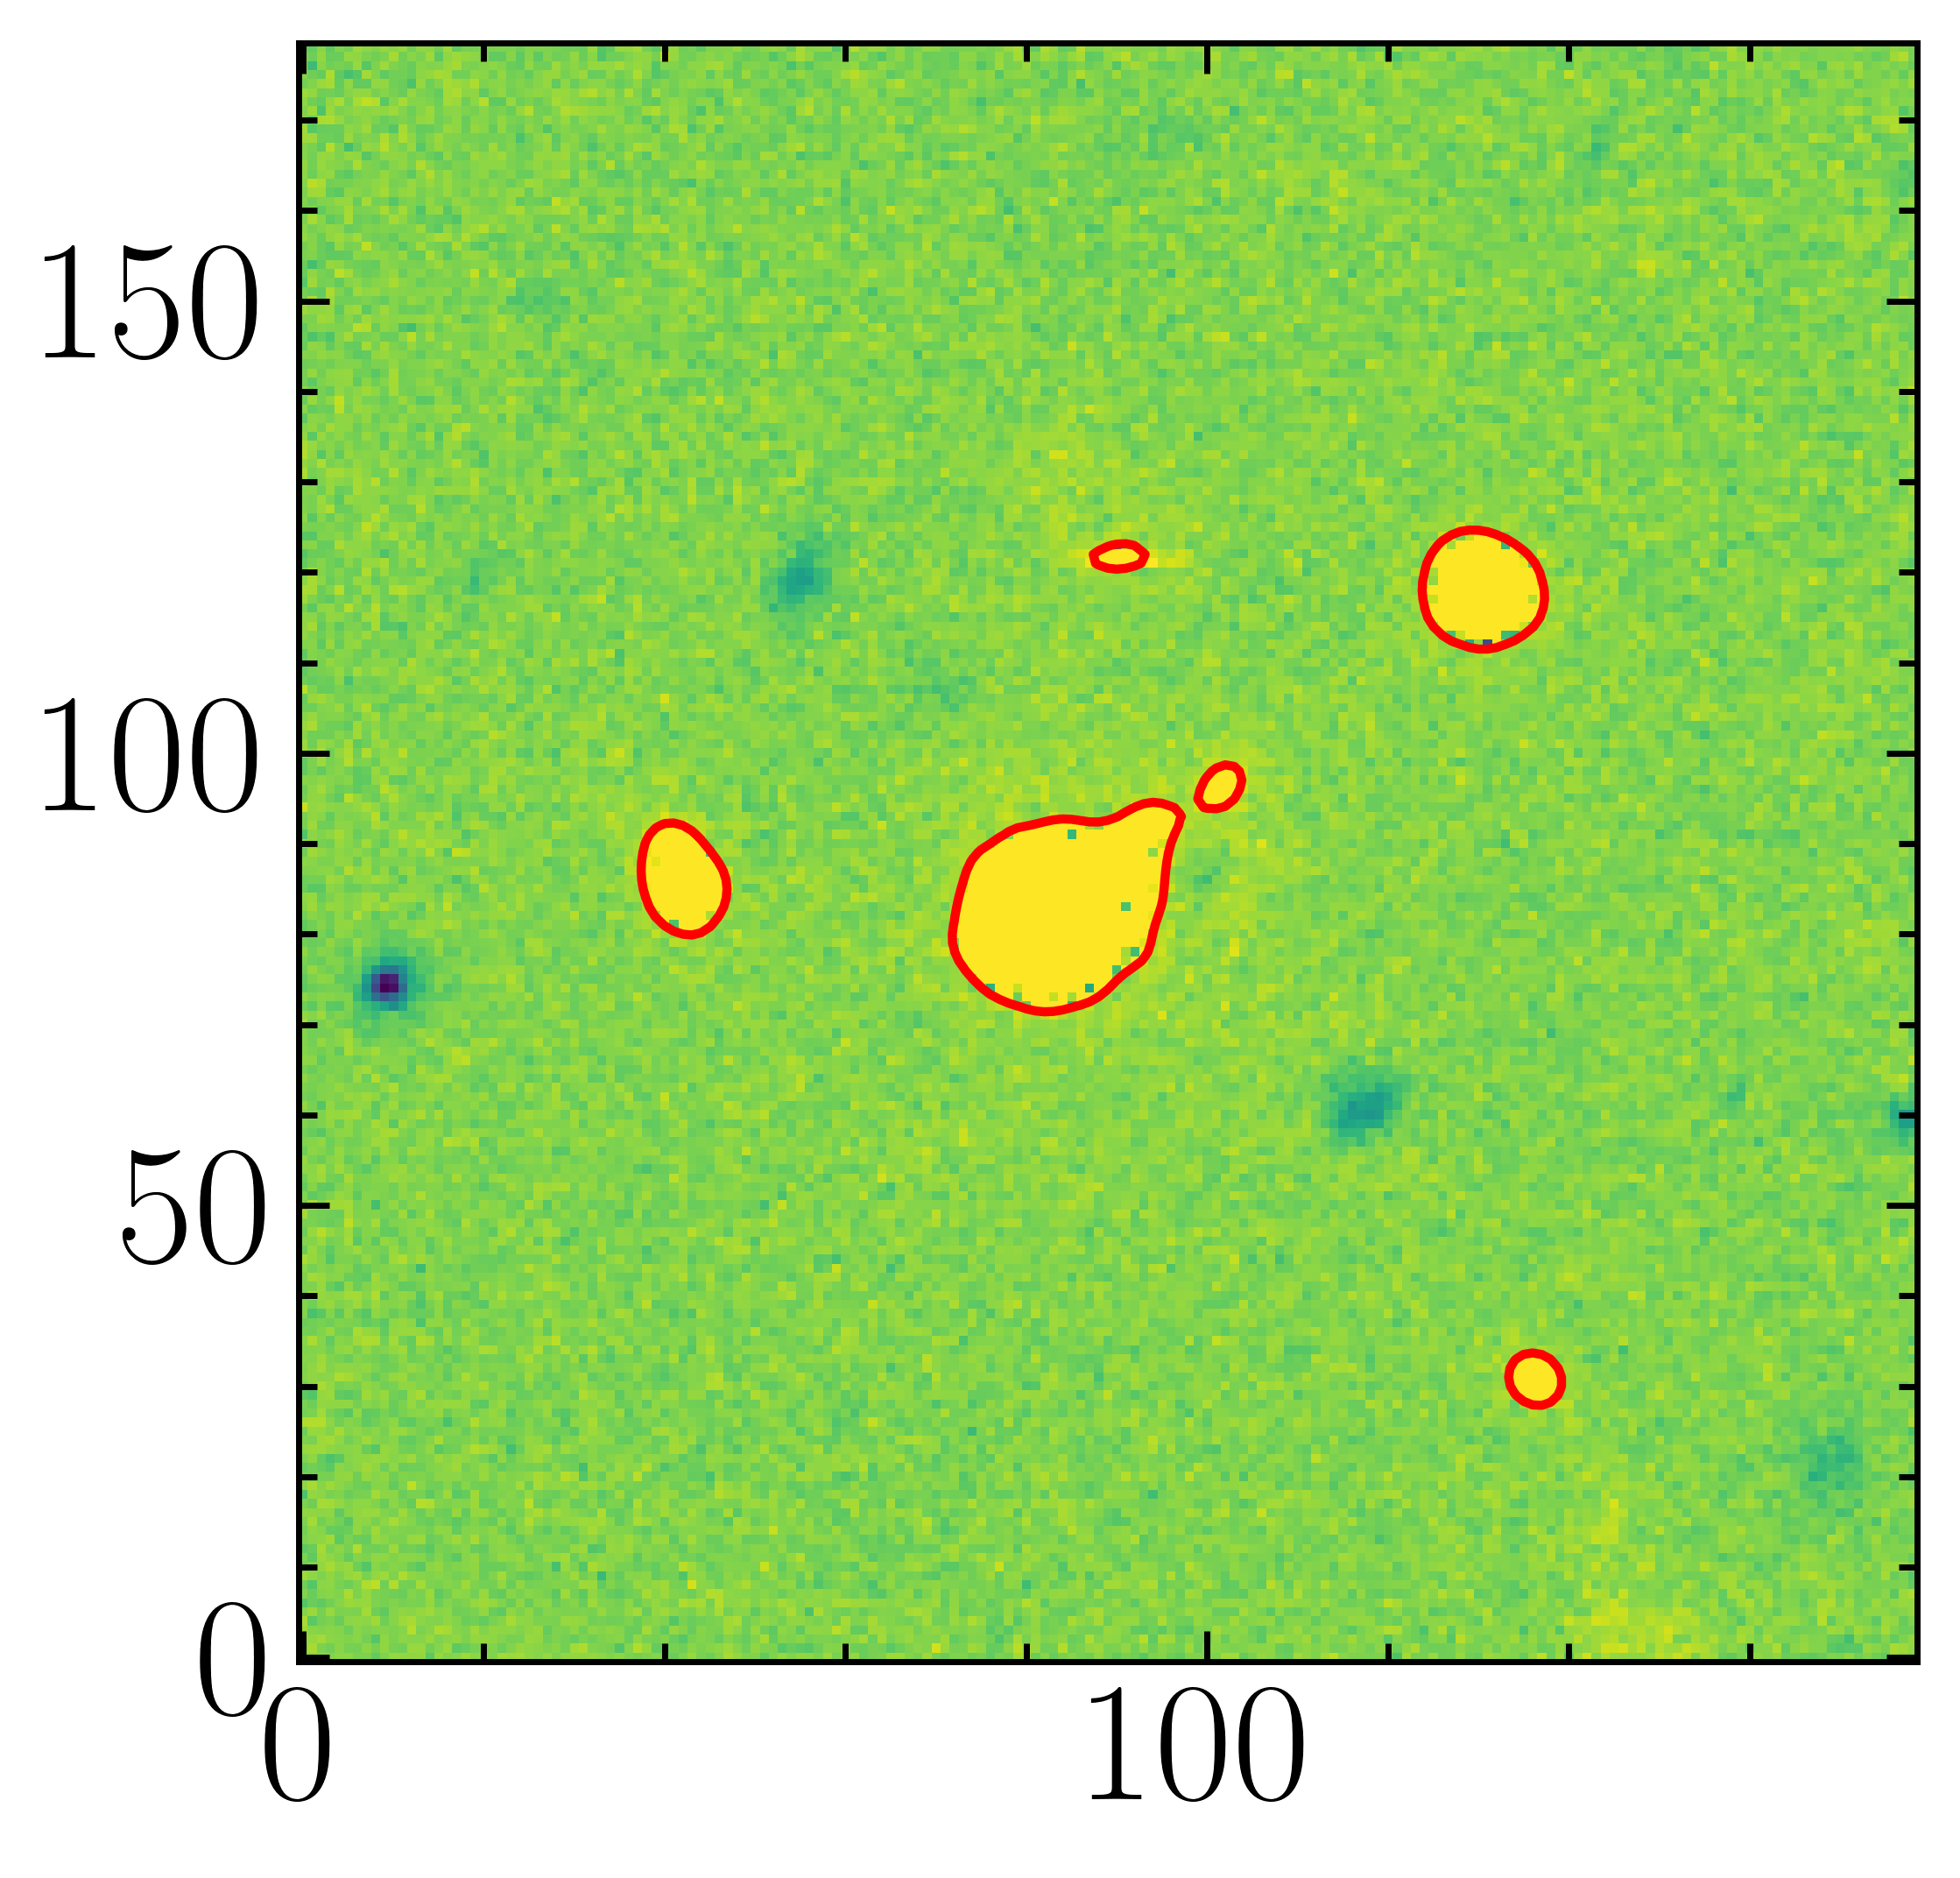

Cutout applied.


In [4]:
OII_nebula = nebula(name='OII', size=30*u.arcsec, apply_cutout=True, choose_std=2, sigma=2)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


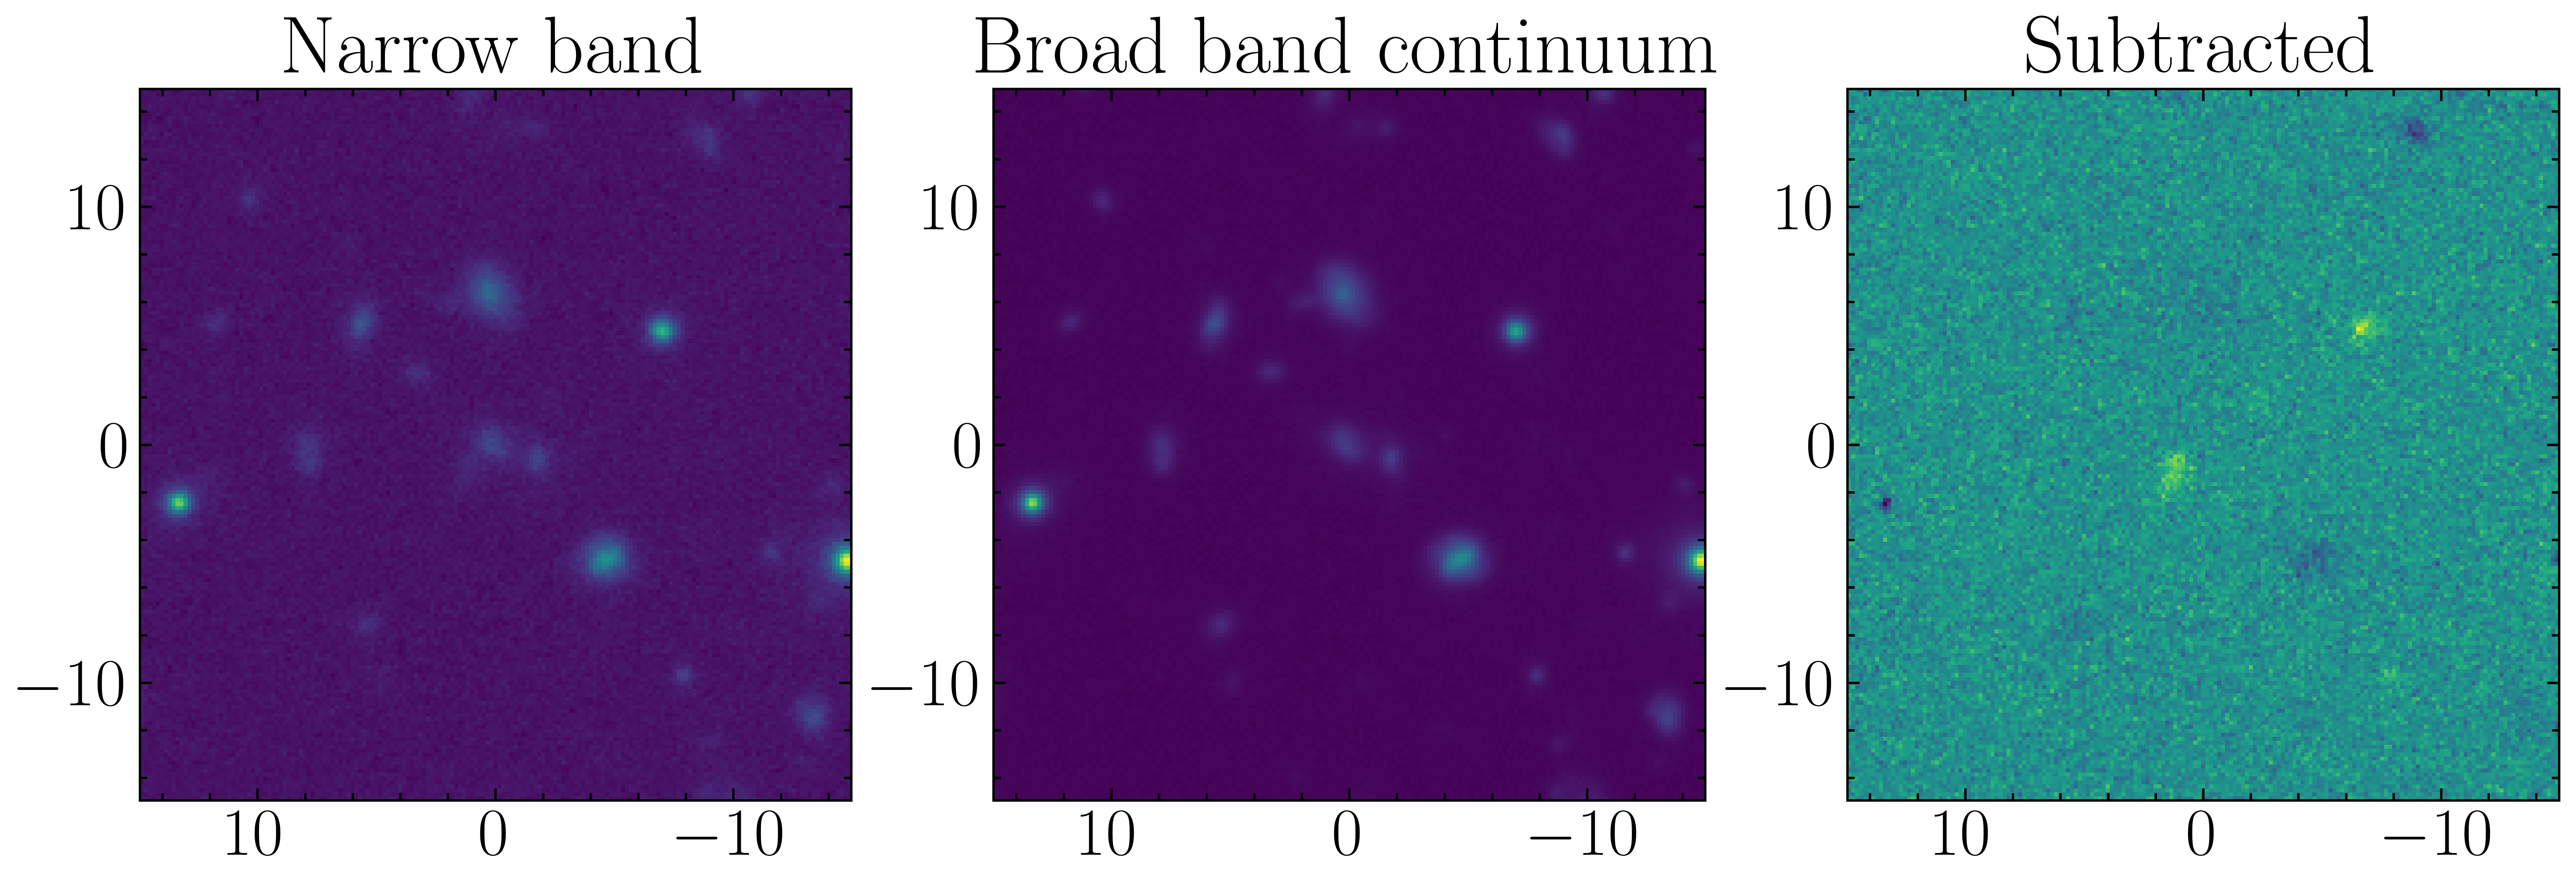

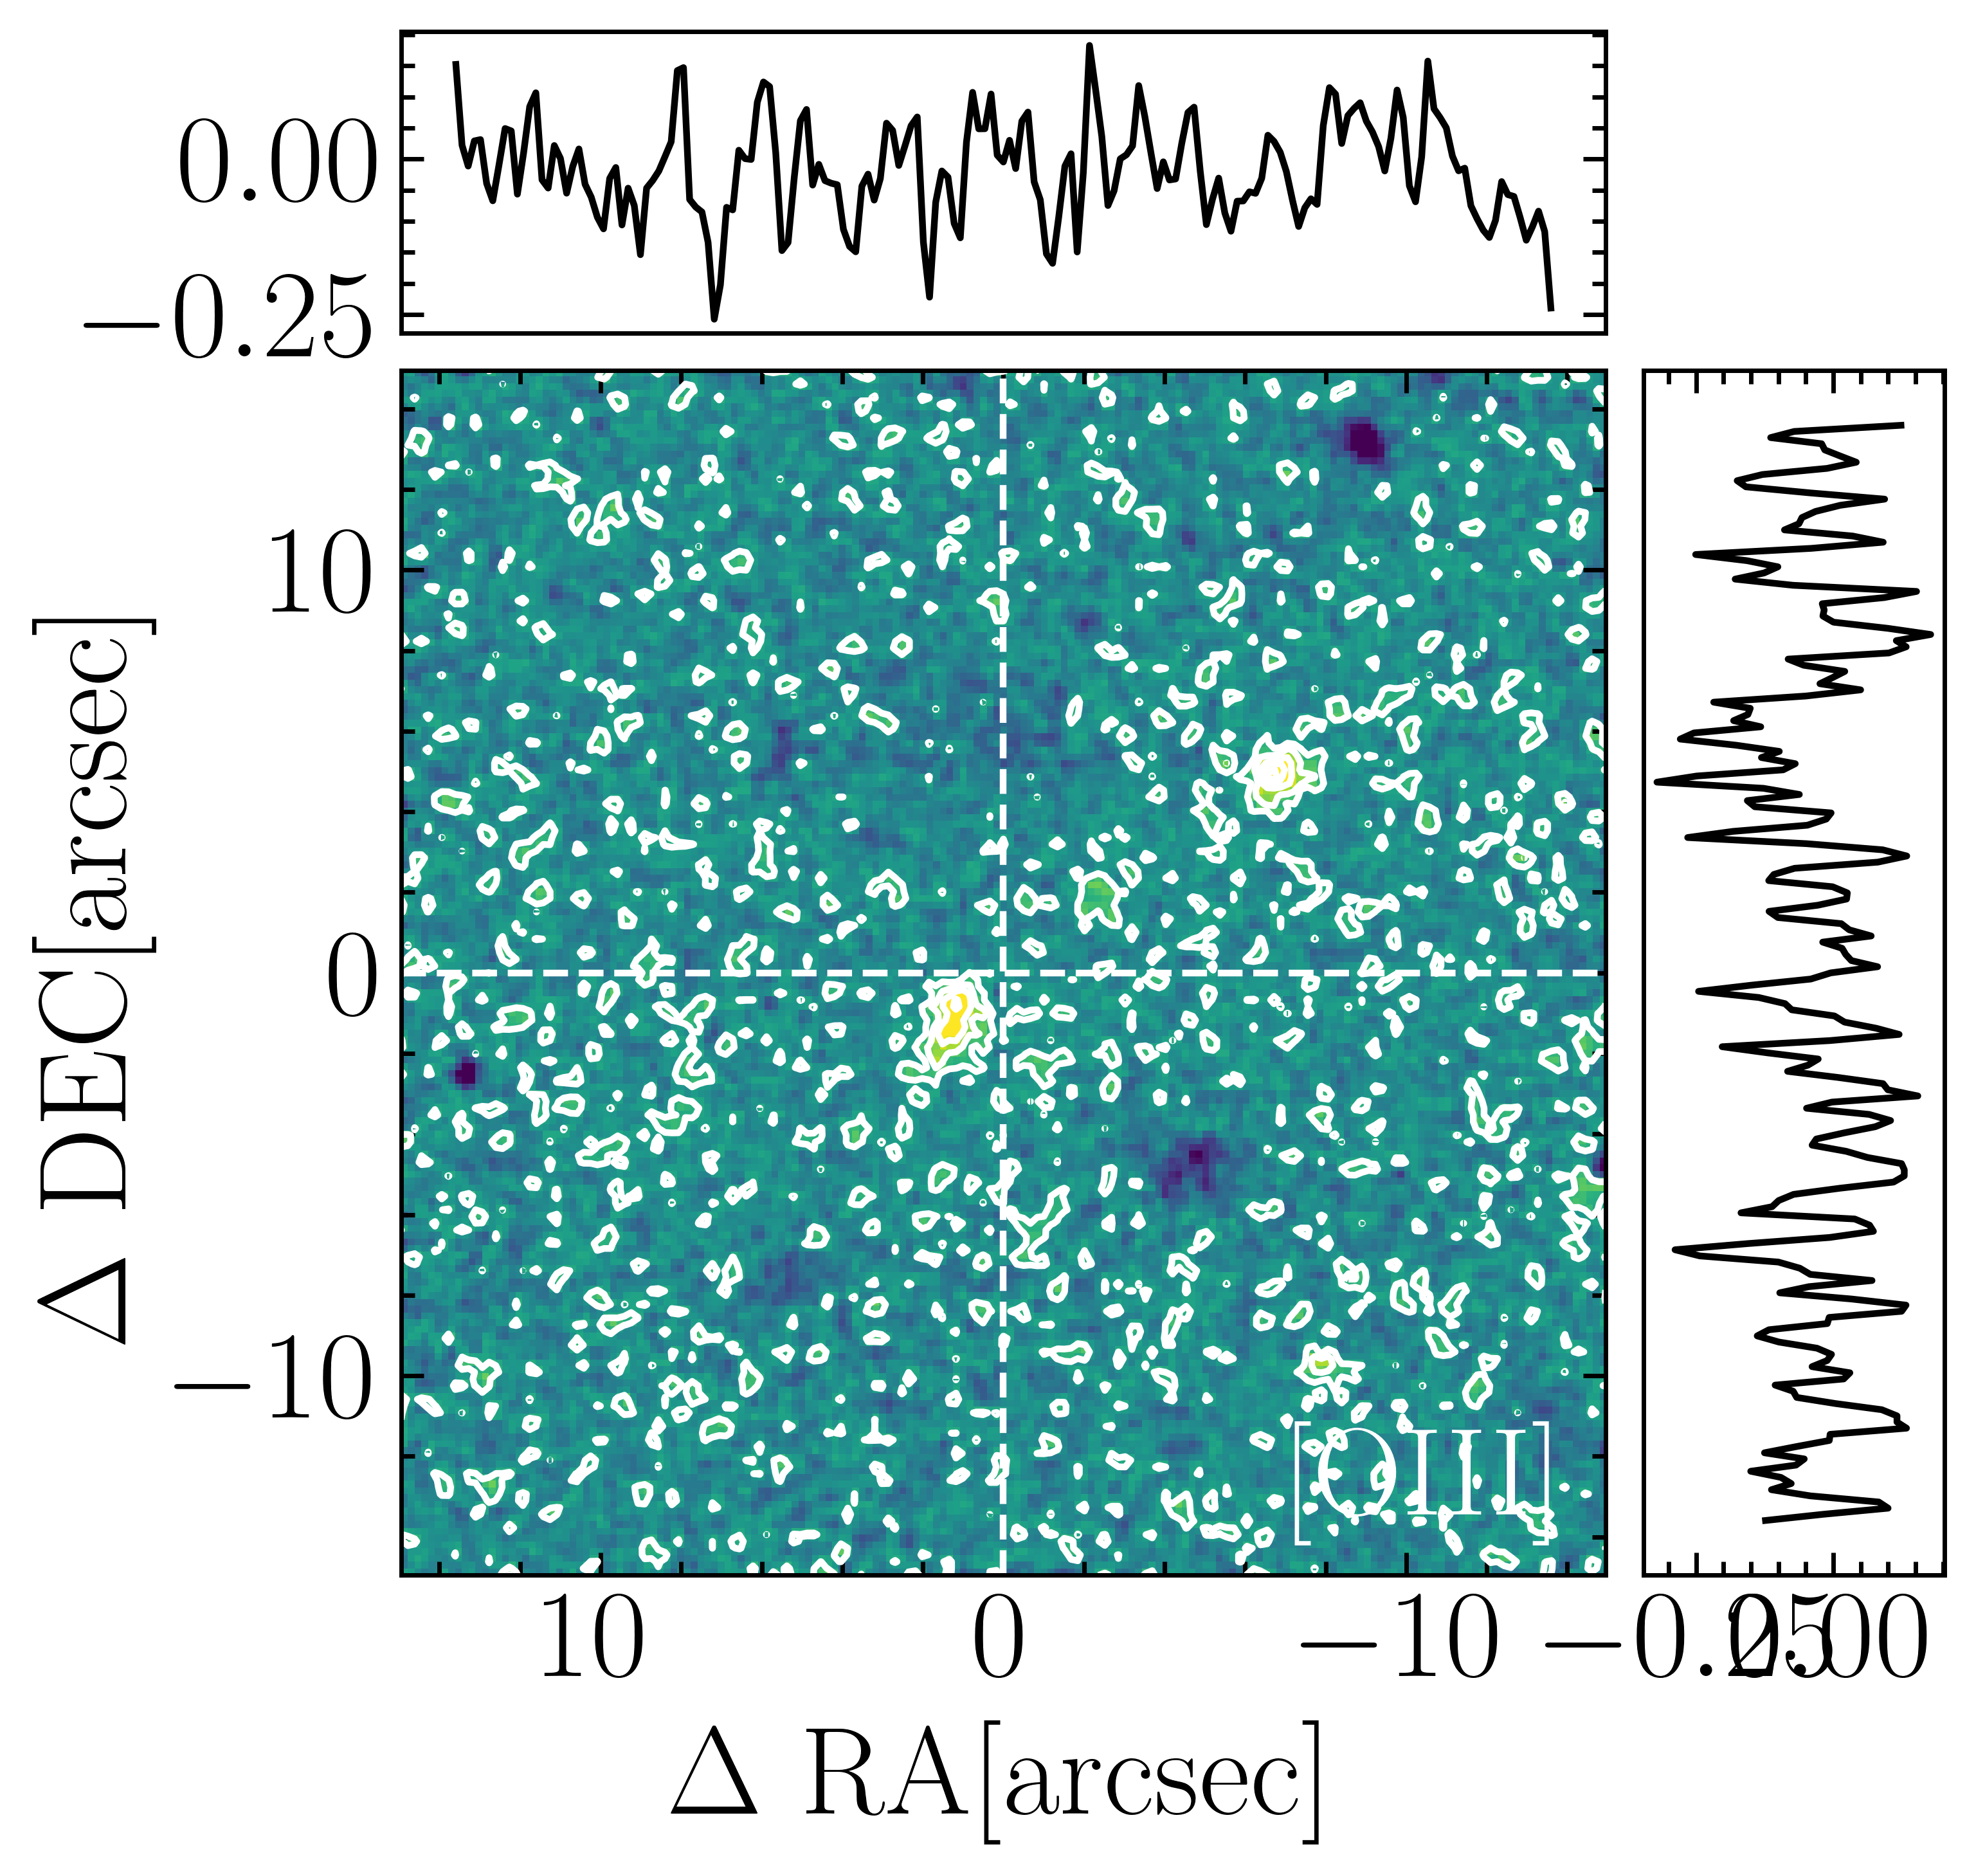

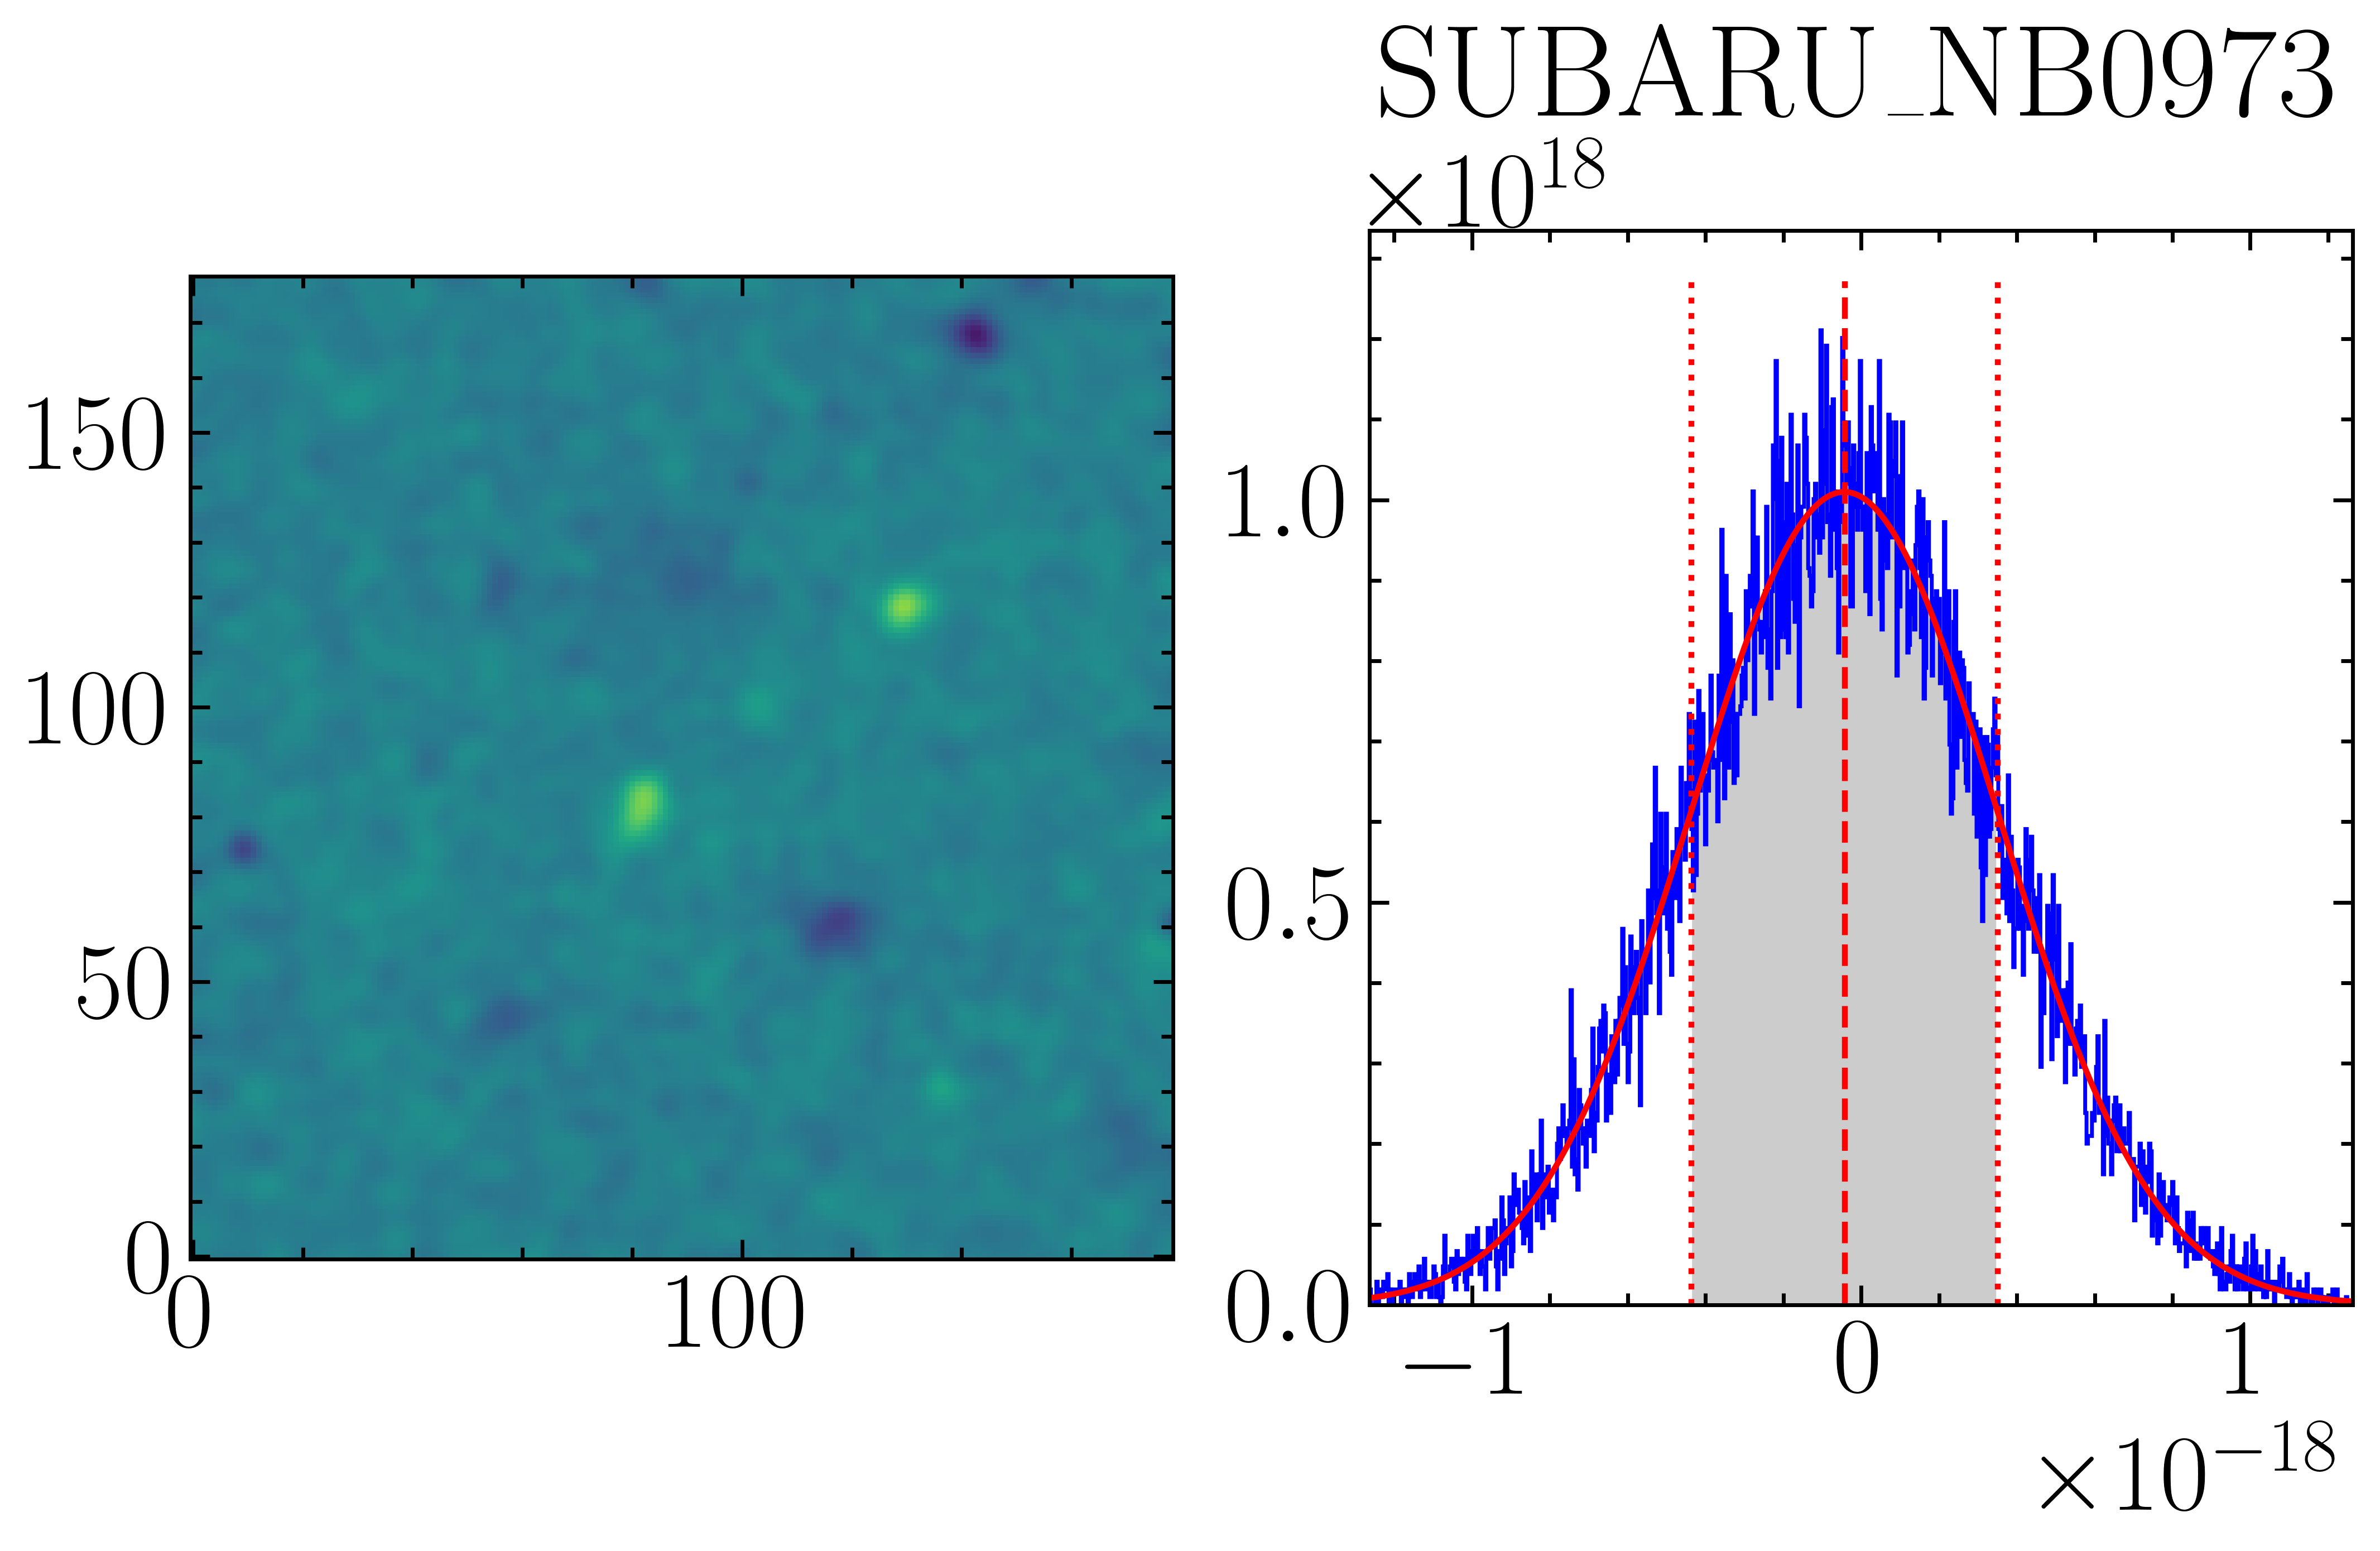

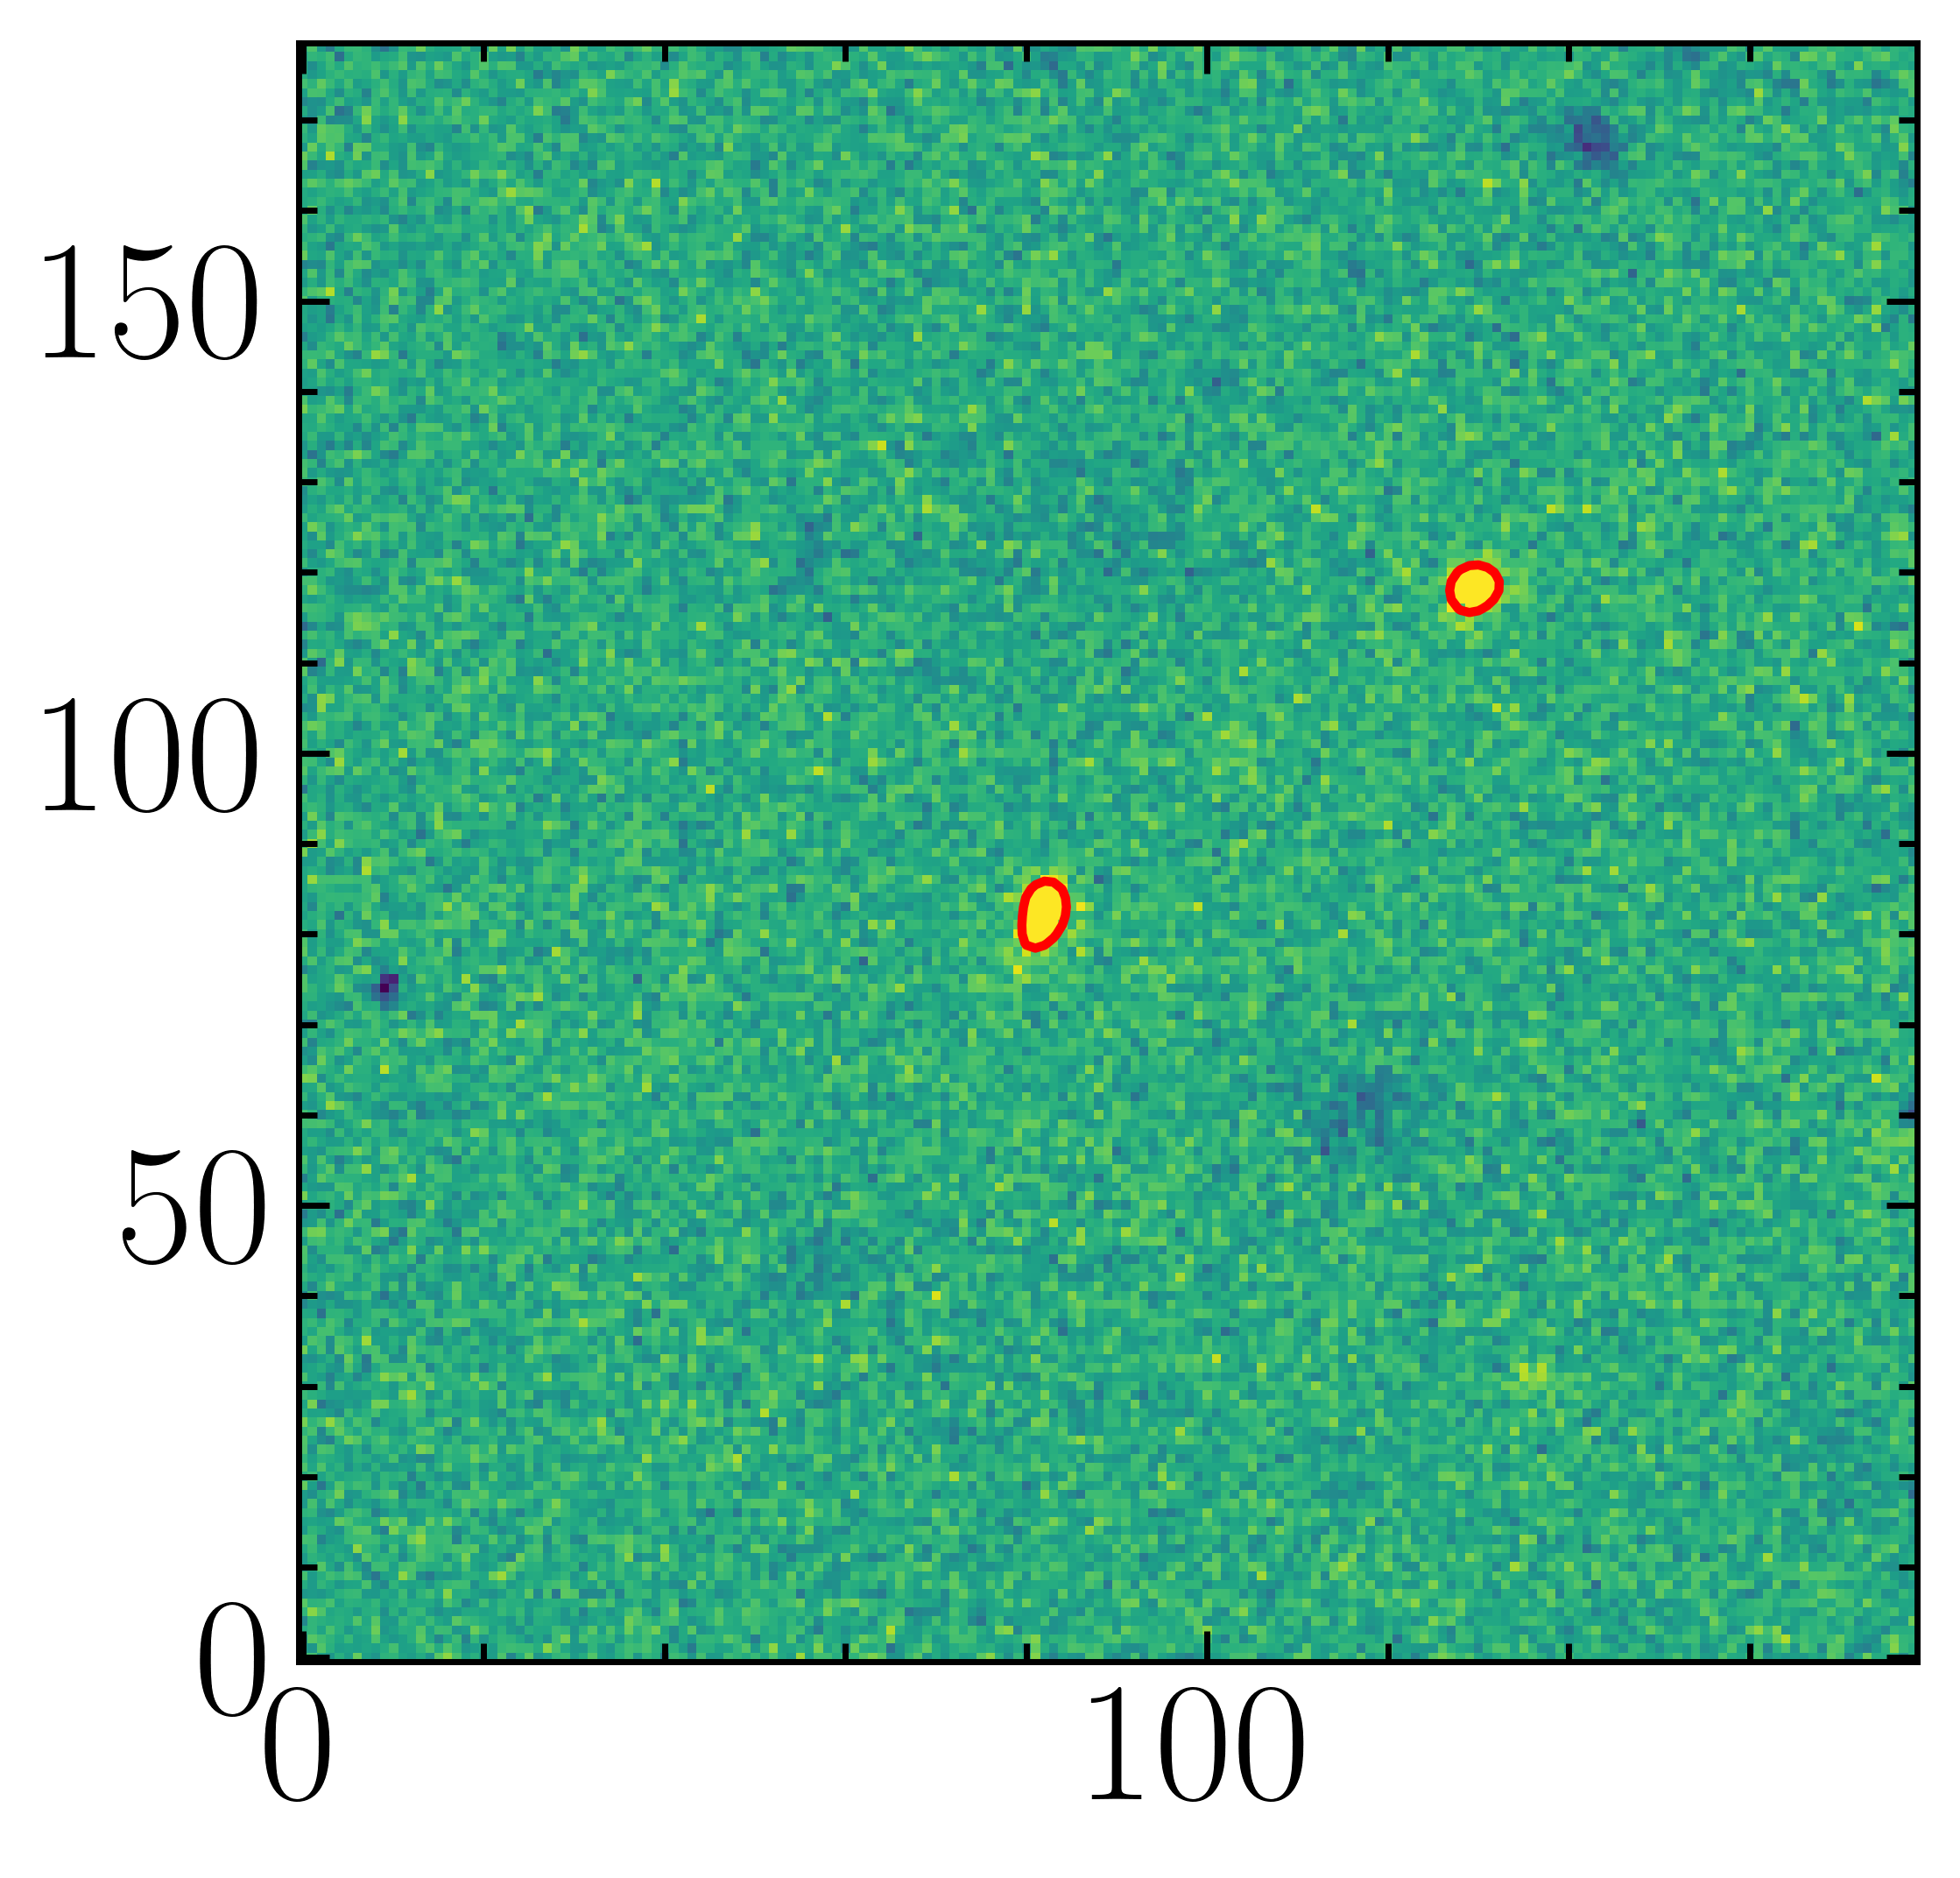

Cutout applied.


In [5]:
OIII_nebula = nebula(name='OIII', size=30*u.arcsec, apply_cutout=True, choose_std=2, sigma=2)

In [ ]:
fits.writeto(filename='data/OII_nebula.fits', data=OII_nebula.data, header=OII_nebula.wcs.to_header(), overwrite=True)
fits.writeto(filename='data/OII_nebula.fits', data=OIII_nebula.data, header=OIII_nebula.wcs.to_header(), overwrite=True)
fits.setval('data/OII_nebula.fits', 'threshold', value=OII_nebula.threshold)
fits.setval('data/OII_nebula.fits', 'threshold', value=OIII_nebula.threshold)
fits.writeto(filename='data/OII_nebula_smooth.fits', data=OII_nebula.smoothed, header=OII_nebula.wcs.to_header(), overwrite=True)
fits.writeto(filename='data/OIII_nebula_smooth.fits', data=OIII_nebula.smoothed, header=OIII_nebula.wcs.to_header(), overwrite=True)
fits.setval('data/OII_nebula_smooth.fits', 'threshold', value=OII_nebula.threshold)
fits.setval('data/OIII_nebula_smooth.fits', 'threshold', value=OIII_nebula.threshold)
fits.writeto(filename='data/OII_nebula_mask.fits', data=OII_nebula.contour_mask.astype(int), overwrite=True)
fits.writeto(filename='data/OIII_nebula_mask.fits', data=OIII_nebula.contour_mask.astype(int), overwrite=True)

# Radial Profile

In [6]:
import numpy as np
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cos = FlatLambdaCDM(70 * u.km / u.s / u.Mpc, Om0 = 0.3,)
z = 0.924

/home/lupengjun/OII_emitter/photometry/code/nebula.py:34: RuntimeWarning: invalid value encountered in scalar divide
  return flux_sum/area


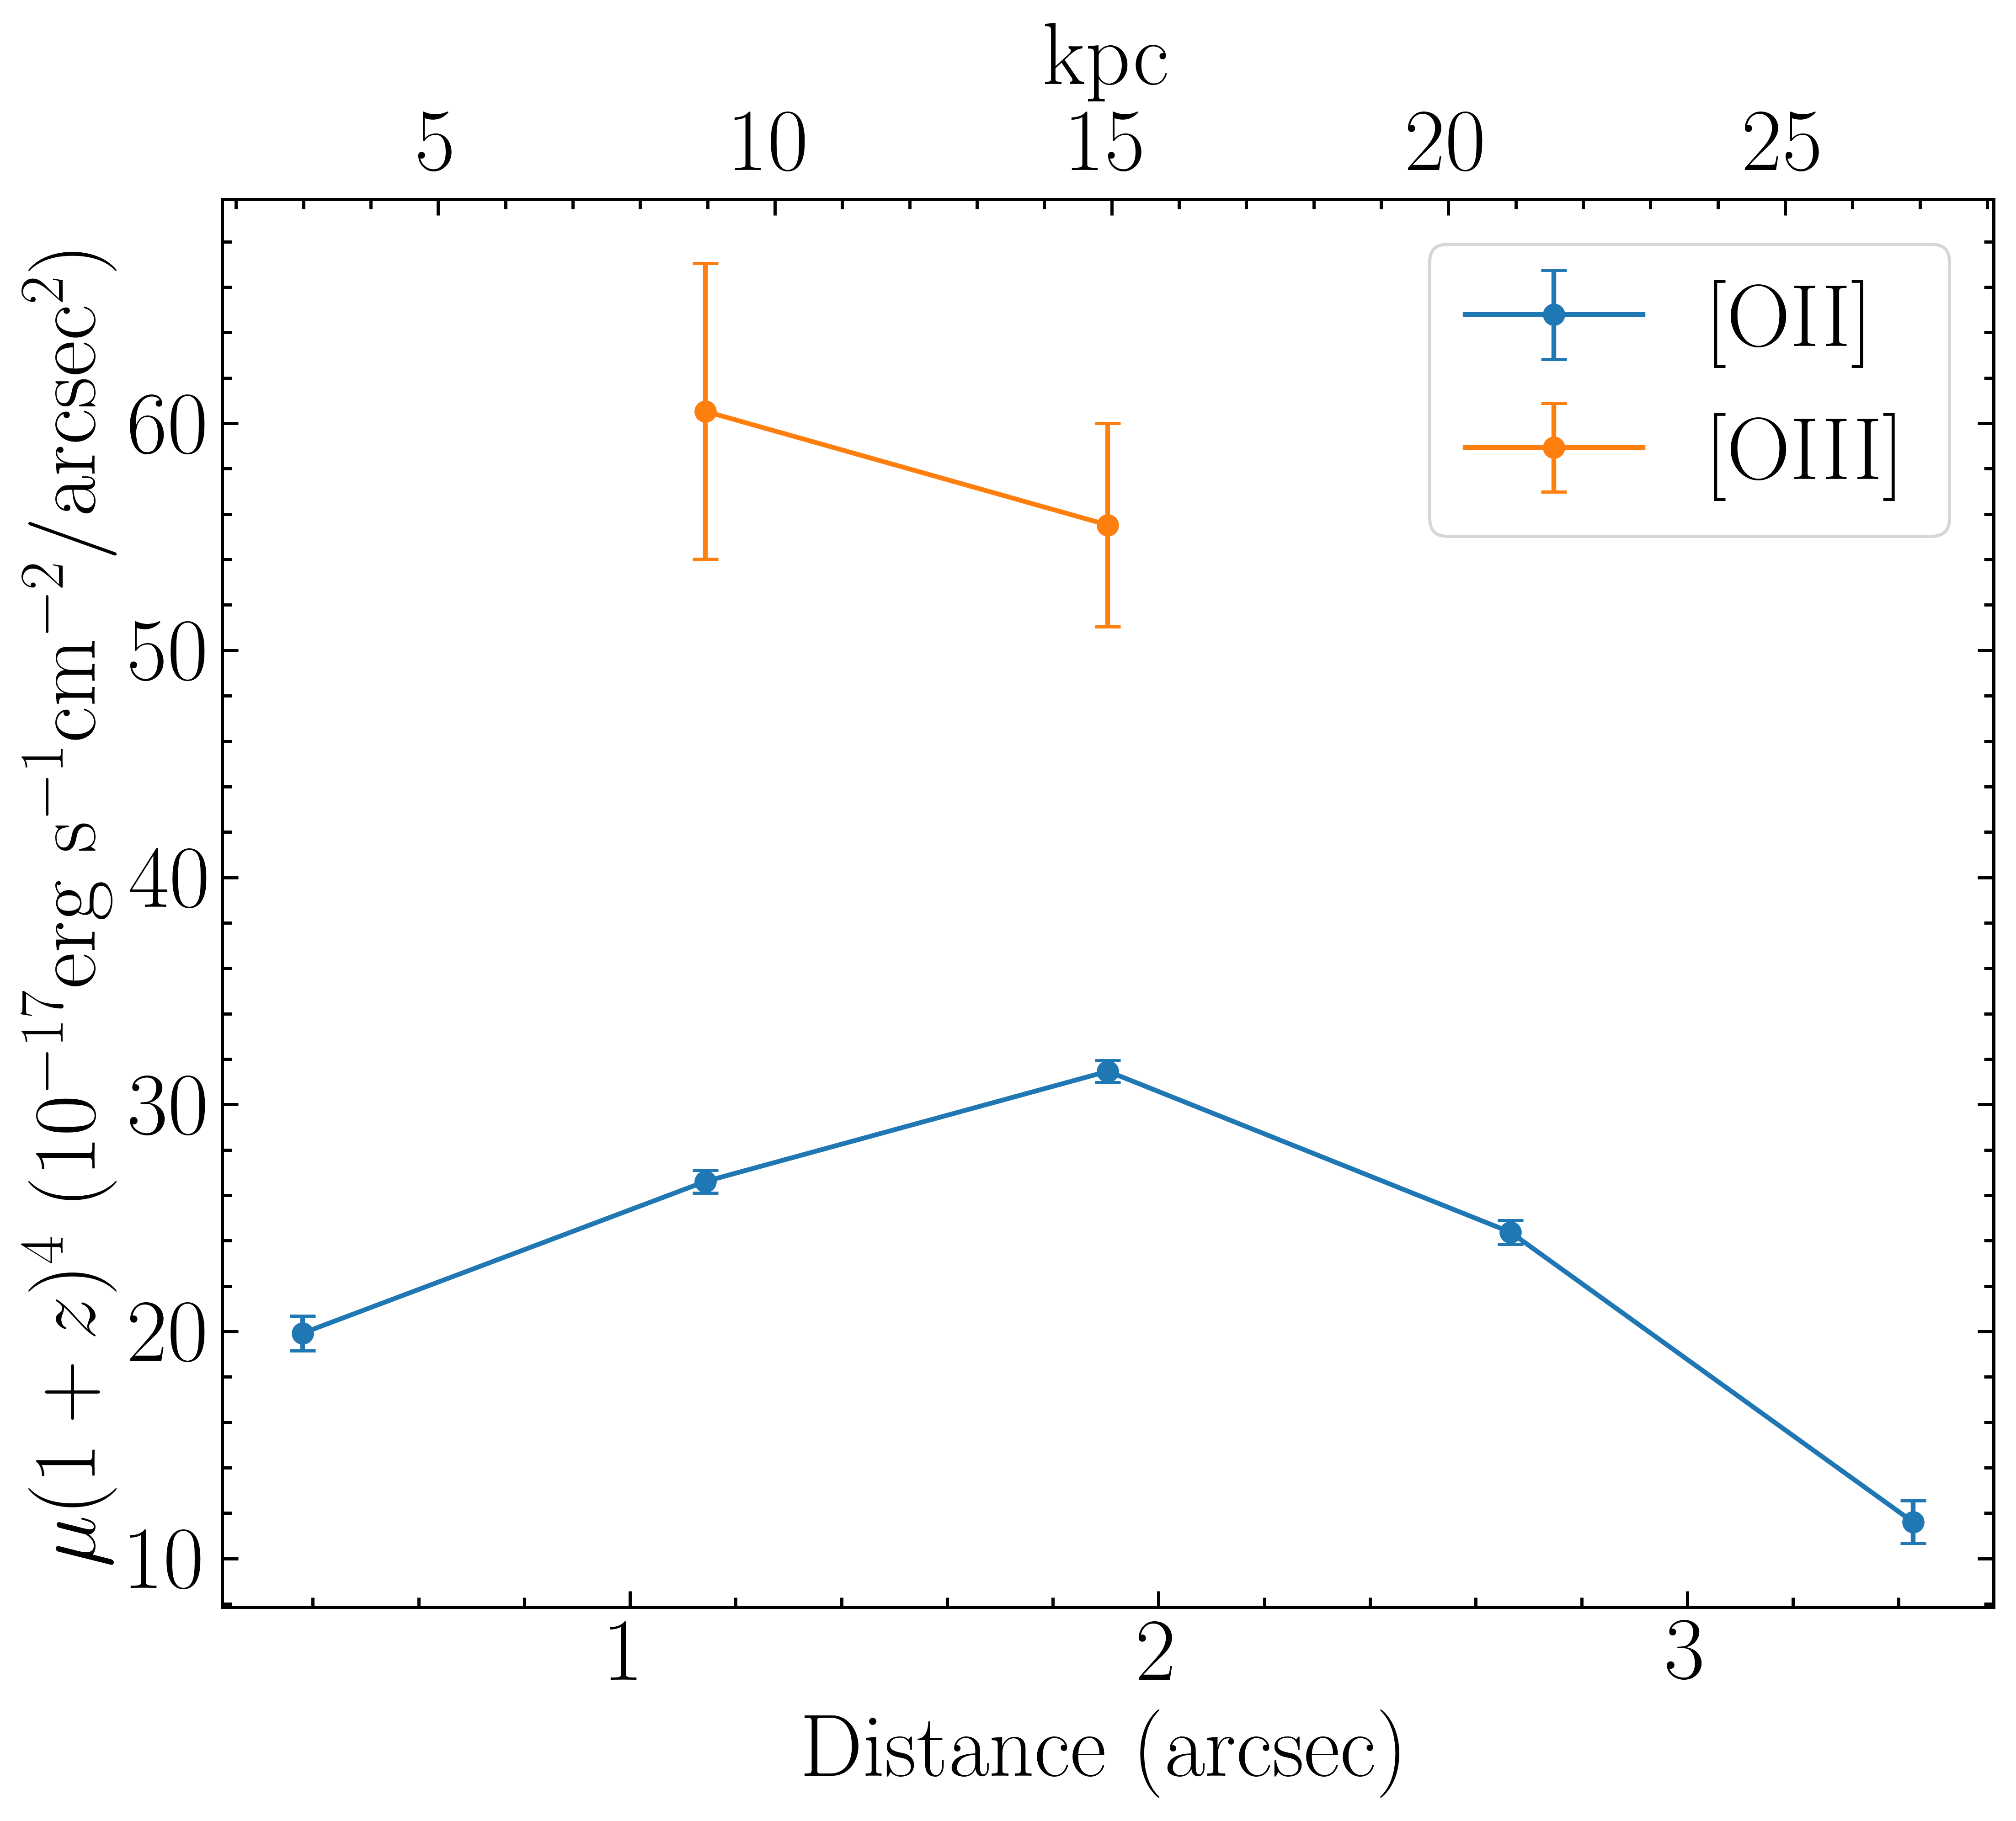

In [7]:
radius3, surface_brightness3, rms3 = OII_nebula.radial_profile(mode='flux')
radius4, surface_brightness4, rms4 = OIII_nebula.radial_profile(mode='flux')
radius3_kpc = cos.angular_diameter_distance(z).to(u.kpc).value*radius3/206265 #kpc
radius4_kpc = cos.angular_diameter_distance(z).to(u.kpc).value*radius4/206265 #kpc
fig, ax = plt.subplots(figsize=(10, 8))
ax.errorbar(radius3, surface_brightness3*(1+z)**4, rms3*(1+z)**4, fmt='-o', label='[OII]', capsize=4)
ax.errorbar(radius4[:-2], (surface_brightness4*(1+z)**4)[:-2], (rms4*(1+z)**4)[:-2], fmt='-o', label='[OIII]', capsize=4)
ax.legend()
ax_ = ax.twiny()
ax_.errorbar(radius3_kpc, surface_brightness3*(1+z)**4, rms3*(1+z)**4, fmt='-o', capsize=4, alpha=0)
ax_.errorbar(radius4_kpc[:-2], (surface_brightness4*(1+z)**4)[:-2], (rms4*(1+z)**4)[:-2], fmt='-^', capsize=4, alpha=0)
ax.set_xlabel('Distance (arcsec)')
ax_.set_xlabel('kpc', labelpad=8)
ax.set_ylabel('$\mu(1+z)^4~(\\rm{10^{-17}erg~s^{-1}cm^{-2}/arcsec^2}$)')
plt.savefig('radial_profile.png', bbox_inches='tight')
plt.show()

In [9]:
radius3_kpc, np.diff(radius3_kpc)

(array([ 2.9888045 ,  8.9664135 , 14.9440225 , 20.92163151, 26.89924051]),
 array([5.977609, 5.977609, 5.977609, 5.977609]))

In [10]:
radius4_kpc, np.diff(radius4_kpc)

(array([ 2.9888045 ,  8.9664135 , 14.9440225 , 20.92163151, 26.89924051]),
 array([5.977609, 5.977609, 5.977609, 5.977609]))

In [27]:
cutout_ = OII_nebula.cutout
wcs = OII_nebula.wcs
extent = np.concatenate([((-np.array(cutout_.bbox_cutout[0])+cutout_.position_cutout[0])*wcs.proj_plane_pixel_scales()[0]).to(u.arcsec).value, 
                            ((np.array(cutout_.bbox_cutout[1])-cutout_.position_cutout[1])*wcs.proj_plane_pixel_scales()[1]).to(u.arcsec).value])
O32_map = OIII_nebula.data/OII_nebula.data
O32_map_smoothed = OIII_nebula.smoothed/OII_nebula.smoothed
O32_map_flat = O32_map[~OII_nebula.contour_mask]
O32_map_masked = np.ma.array(O32_map, mask=~OII_nebula.contour_mask)
O32_map_smoothed_masked = np.ma.array(O32_map_smoothed, mask=~OII_nebula.contour_mask)

In [ ]:
pandas = pyregion.open('/home/lupengjun/OII_emitter/photometry/code/radial_profile/pandas_suit.reg')
patch_list, artist_list = pandas.get_mpl_patches_texts()

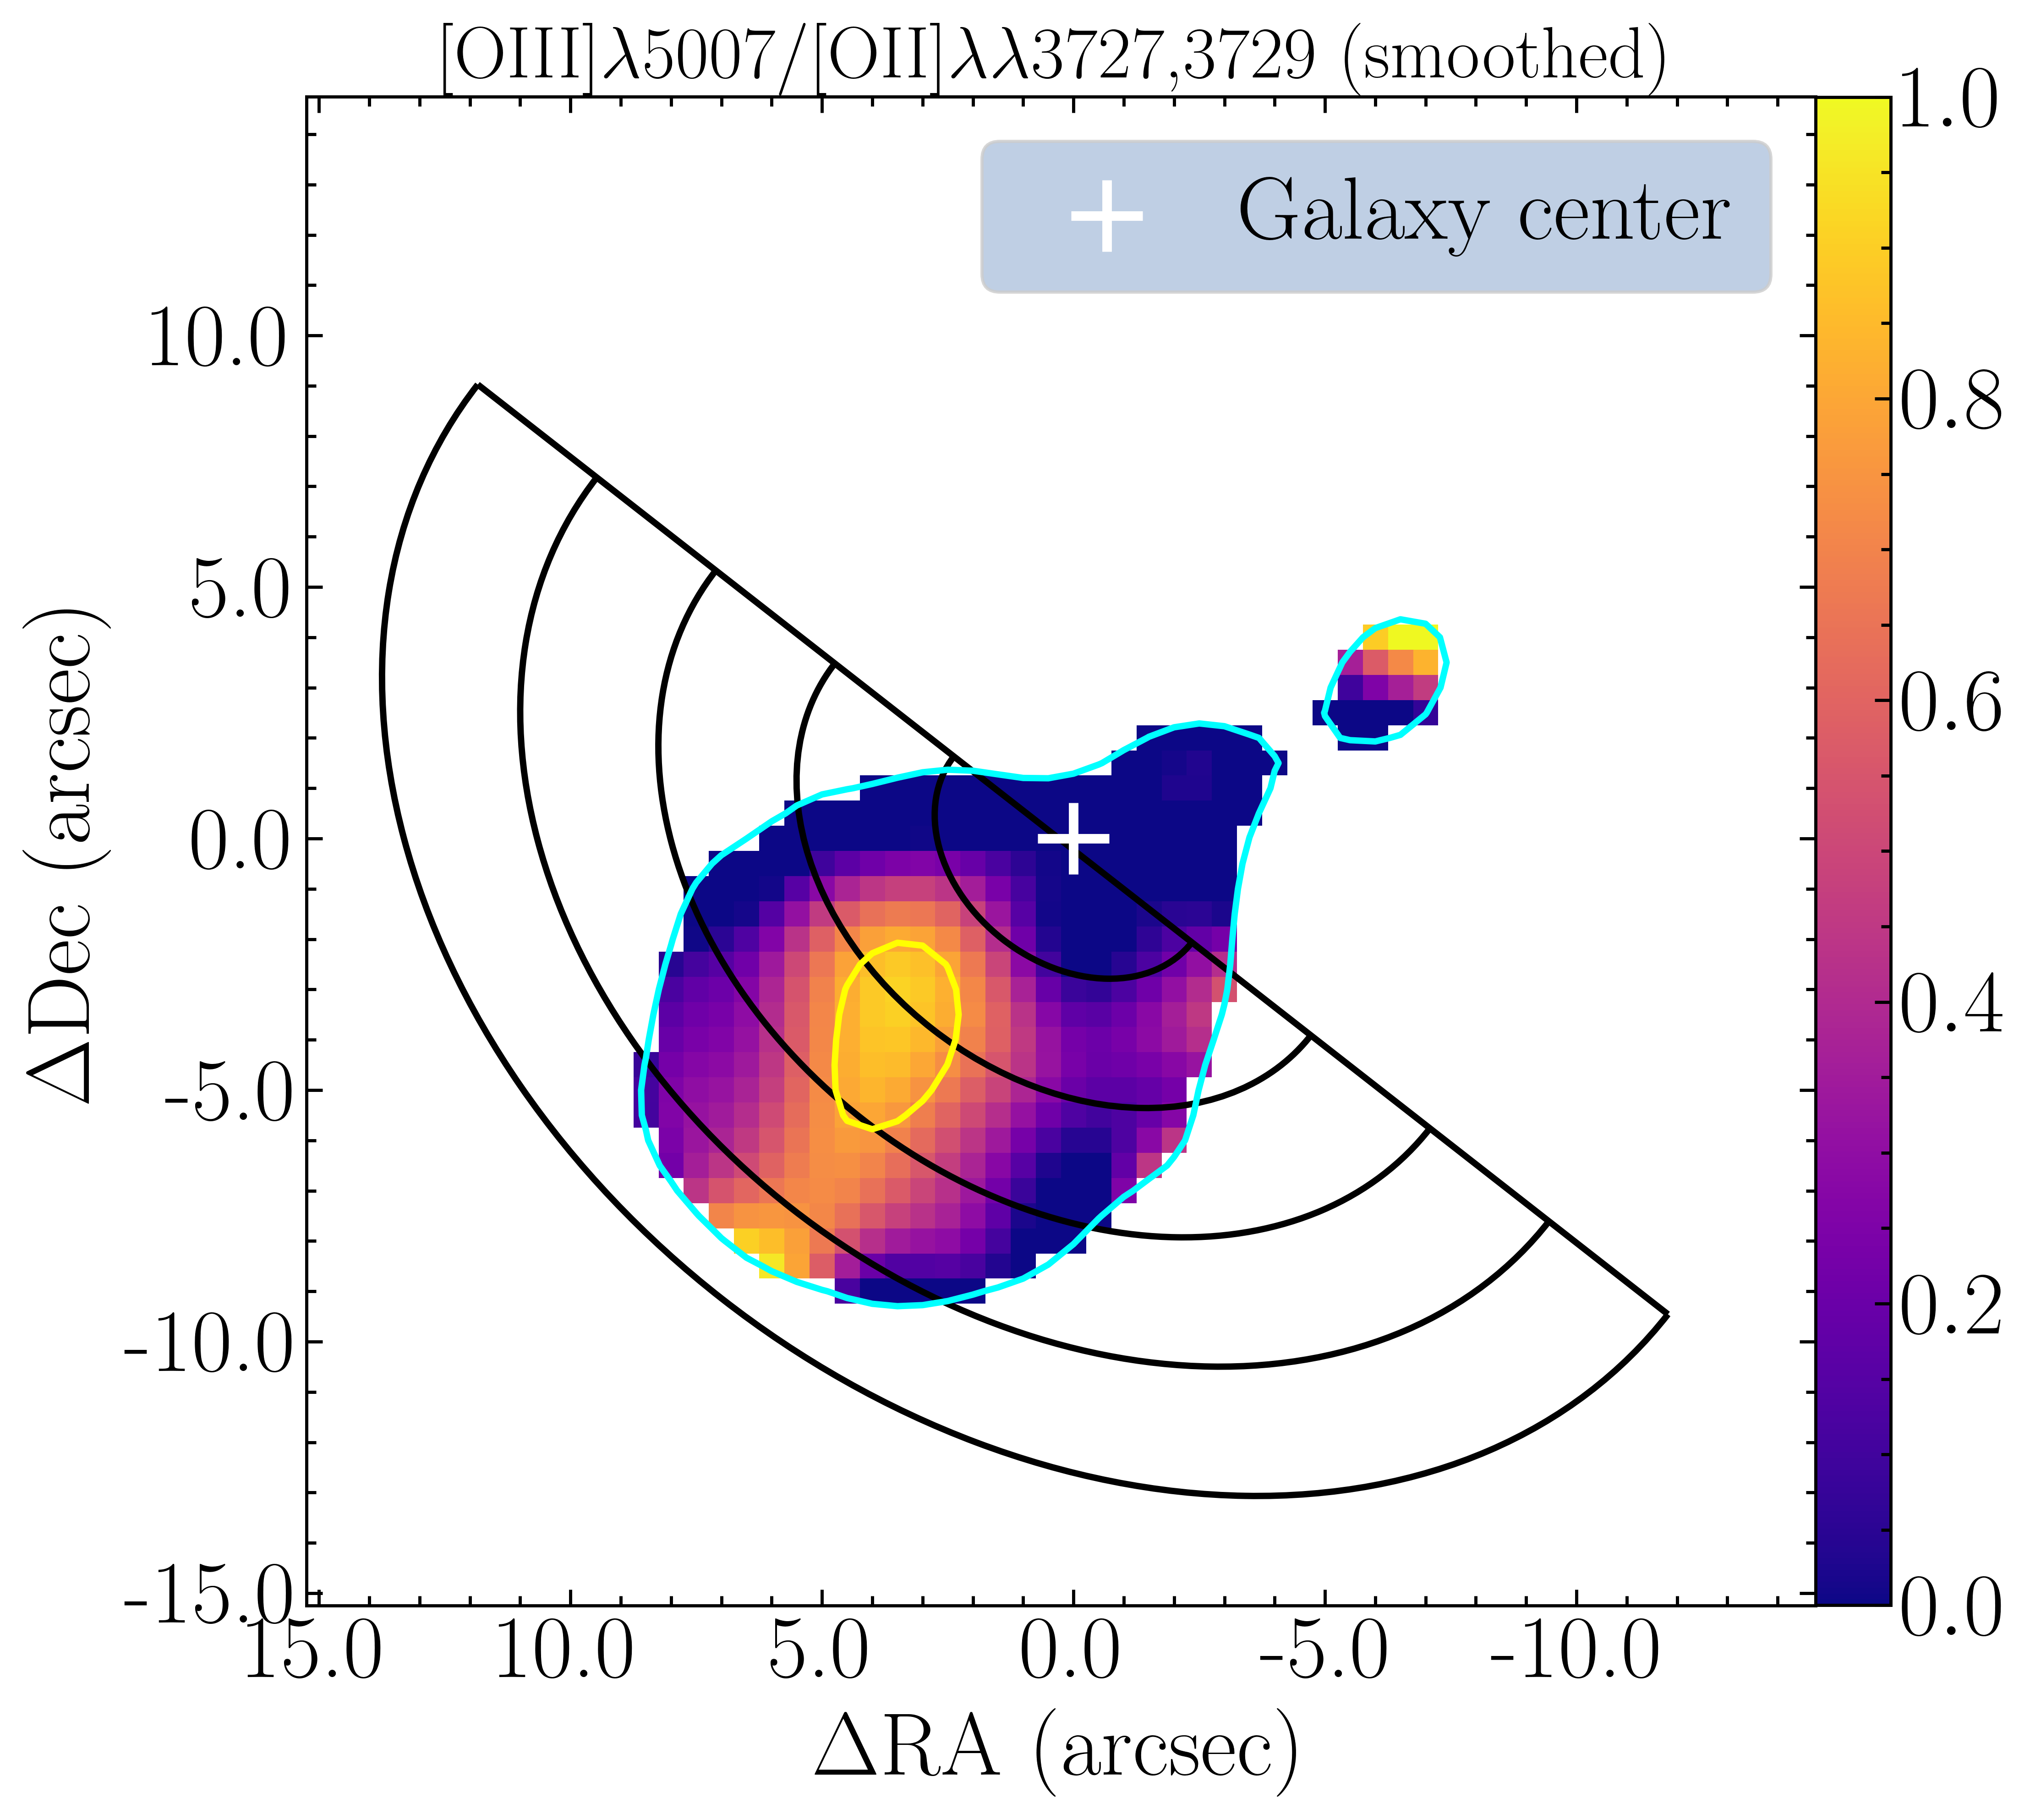

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
cb = ax.imshow(O32_map_smoothed_masked, origin='lower', vmax=1, vmin=0., cmap='plasma')
fig.colorbar(cb, pad=0, shrink=0.855)
ax.set_xlabel('$\Delta$RA (arcsec)')
ax.set_ylabel('$\Delta$Dec (arcsec)')
ax.set_title('[OIII]$\lambda$5007/[OII]$\lambda\lambda$3727,3729 (smoothed)', fontsize=23)
ax.contour(OII_nebula.smoothed, levels=[OII_nebula.threshold], colors='cyan', linewidths=2)
ax.contour(OIII_nebula.smoothed, levels=[OIII_nebula.threshold], colors='yellow', linewidths=2)
ax.set_xticks(np.arange(0, 70, 10), np.around(np.linspace(15, -15, 7), 0).astype(str))
ax.set_yticks(np.arange(0, 70, 10), np.around(np.linspace(-15, 15, 7), 0).astype(str)) 
for p in patch_list:
    new_p = copy(p)
    new_p.set_edgecolor('k')
    new_p.set_linewidth(2)
    ax.add_patch(new_p)
ax.scatter(30, 30, marker='+', s=500, c='w', label='Galaxy center', lw=3)
plt.legend(facecolor='lightsteelblue', handletextpad=0.5)
plt.savefig('O32_map_smoothed.png', bbox_inches='tight')
plt.show()